<div style="text-align: center;">
    <h1>Home Credit Risk - Predicción</h1>
</div>


## Índice

- [1 - Preparación de Datos](#preparaciondedatos)
- [1.1 - Carga de Datos](#cargadedatos)
- [1.2 - Limpieza de Datos](#limpiezadedatos)
- [1.3 - Transformación de Datos](#transformaciondedatos)
- [2 - Exploración de los Datos](#exploraciondedatos)
- [3 - Modelado](#modeladodedatos)
- [3.1 - Introducción](#intromodelado)
- [3.2 - SelectFromModel](#selectfrommodel)
- [3.3 - GridSearch](#gridsearch)
- [3.4 - Conclusión](#conclusion)
- [4 - Interpretación de Resultados](#conclusion)

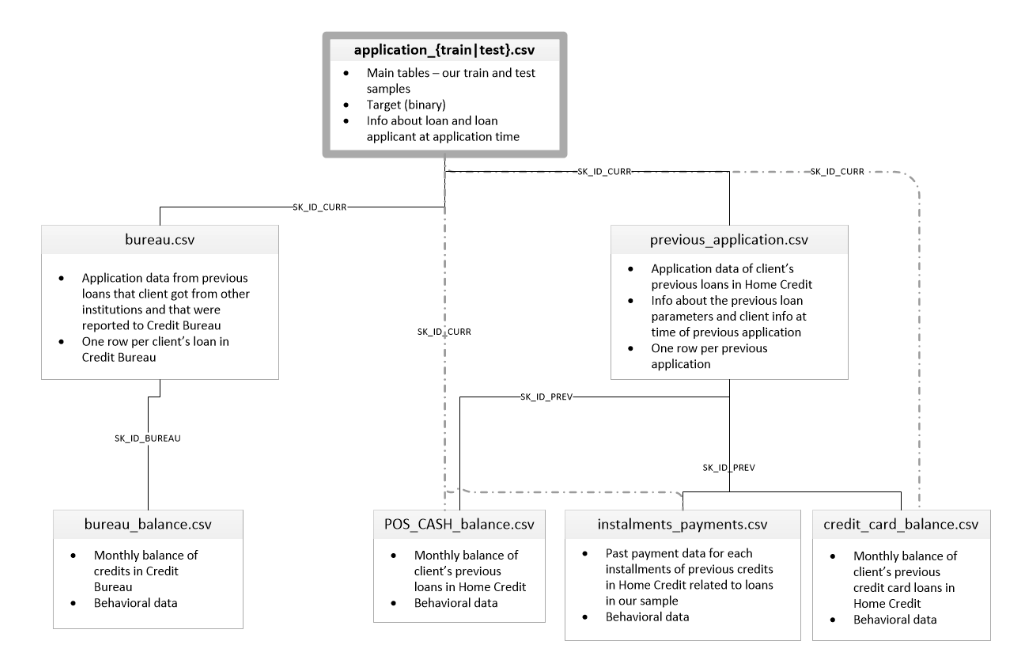

<div id="objetivo" style="text-align: left;">
    <h4>Objetivo</h4>
</div>

El objetivo principal de este proyecto es desarrollar un modelo de clasificación que permita determinar la elegibilidad de los clientes para la concesión de un préstamo bancario, basándose en la variable de destino ("target"). Esta variable indicará si a un cliente se le puede otorgar un préstamo (0) o no (1).

Para lograr este objetivo, se llevará a cabo un análisis exhaustivo de los datos disponibles, que incluirán información demográfica, financiera y de comportamiento de los clientes. 

<div id="instalacion-de-librerias" style="text-align: left;">
    <h4>Instalación de Librerías</h4>
</div>

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


<div style="text-align: left;">
    <h4>Carga de Librerias</h4>
</div>

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 122)
pd.set_option('display.max_columns', None)

<div style="text-align: left;">
    <h4>Carga de Funciones</h4>
</div>

In [3]:
# Se define función que cuenta la cantidad de valores nulos en cada columna de un DataFrame y se calcula
# el porcentaje de valores nulos por columna.

def contar_valores_nulos_con_porcentaje(dataframe):

    nulos_por_columna = dataframe.isnull().sum()
    porcentaje_nulos_por_columna = (nulos_por_columna / len(dataframe)) * 100

    resultados = pd.DataFrame({
        'Cantidad de Nulos': nulos_por_columna,
        'Porcentaje de Nulos (%)': porcentaje_nulos_por_columna
    })

    return resultados

#Se define función que elimina los valores atípicos de una columna específica en un DataFrame.
#La misma utiliza el método de rango intercuartílico para identificar valores atípicos, que son aquellos puntos de datos
#que caen fuera del rango definido por el primer cuartil (Q1) y el tercer cuartil (Q3).

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

#Se define función que elimina iterativamente los valores atípicos de una columna específica en un DataFrame hasta que
#no se encuentren más valores atípicos según el criterio del rango intercuartílico definido en la función "remove_outliers".

def remove_outliers_iteratively(df, column_name):
    df_clean = df.copy()
    while True:
        initial_len = len(df_clean)
        df_clean = remove_outliers(df_clean, column_name)
        final_len = len(df_clean)
        if initial_len == final_len:
            break
    return df_clean

In [4]:
def count_outliers(df, column):
    """
    Cuenta el número de valores atípicos en una columna específica de un DataFrame.

    Args:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna en la que se contarán los valores atípicos.

    Returns:
    int: El número de valores atípicos en la columna especificada.
    """
    # Calcular Q1 (primer cuartil), Q3 (tercer cuartil) y el IQR (rango intercuartílico)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los valores atípicos
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]

    return num_outliers

<div id="preparaciondedatos" style="text-align: center;">
    <h2><u>Preparación de Datos</u></h2>
</div>


<div id="cargadedatos" style="text-align: center;">
    <h3><u>Carga de Datos</u></h3>
</div>

In [5]:
# Read application_train.csv
application_train = pd.read_csv('application_train.csv')

# Read bureau_balance.csv
bureau_balance = pd.read_csv('bureau_balance.csv')

# Read bureau.csv
bureau = pd.read_csv('bureau.csv')

# Read credit_card_balance.csv
credit_card_balance = pd.read_csv('credit_card_balance.csv')

# Read installments_payments.csv
installments_payments = pd.read_csv('installments_payments.csv')

# Read POS_CASH_balance.csv
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')

# Read previous_application.csv
previous_application = pd.read_csv('previous_application.csv')

<h5><u>Application_train</u></h5>

Esta es la tabla principal, dividida en dos archivos: train (con columna Target) y test (sin columna Target)
Son datos estáticos. Cada fila representa un préstamo en nuestra muestra de datos.

**SK_ID_CURR** - ID del préstamo en nuestra muestra.

**TARGET** - Variable objetivo (1 - cliente con dificultades de pago: tuvo un pago atrasado de más de X días en al menos una de las primeras Y cuotas del préstamo en nuestra muestra, 0 - en todos los demás casos).

**NAME_CONTRACT_TYPE** - Identificación si el préstamo es en efectivo o rotativo.

**CODE_GENDER** - Género del cliente.

**FLAG_OWN_CAR** - Indicador si el cliente tiene un coche propio.

**FLAG_OWN_REALTY** - Indicador si el cliente tiene una casa o piso propio.

**CNT_CHILDREN** - Número de hijos que tiene el cliente.

**AMT_INCOME_TOTAL** - Ingreso total del cliente.

**AMT_CREDIT** - Monto de crédito del préstamo.

**AMT_ANNUITY** - Anualidad del préstamo.

**AMT_GOODS_PRICE** - Para préstamos de consumo, es el precio de los bienes para los cuales se otorga el préstamo.

**NAME_TYPE_SUITE** - Quién acompañaba al cliente cuando solicitó el préstamo.

**NAME_INCOME_TYPE** - Tipo de ingreso del cliente (empresario, trabajador, permiso de maternidad, ...).

**NAME_EDUCATION_TYPE** - Nivel de educación más alto que alcanzó el cliente.

**NAME_FAMILY_STATUS** - Estado civil del cliente.

**NAME_HOUSING_TYPE** - Situación de vivienda del cliente (alquiler, viviendo con padres, ...).

**REGION_POPULATION_RELATIVE** - Población normalizada de la región donde vive el cliente (un número más alto significa que el cliente vive en una región más poblada).

**DAYS_BIRTH** - Edad del cliente en días en el momento de la solicitud.

**DAYS_EMPLOYED** - Cuántos días antes de la solicitud comenzó el empleo actual de la persona.

**DAYS_REGISTRATION** - Cuántos días antes de la solicitud cambió el cliente su registro.

**DAYS_ID_PUBLISH** - Cuántos días antes de la solicitud cambió el cliente el documento de identidad con el que solicitó el préstamo.

**OWN_CAR_AGE** - Edad del coche del cliente.

**FLAG_MOBIL** - ¿Proporcionó el cliente teléfono móvil? (1=SÍ, 0=NO).

**FLAG_EMP_PHONE** - ¿Proporcionó el cliente teléfono laboral? (1=SÍ, 0=NO).

**FLAG_WORK_PHONE** - ¿Proporcionó el cliente teléfono doméstico? (1=SÍ, 0=NO).

**FLAG_CONT_MOBILE** - ¿Era alcanzable el teléfono móvil del cliente? (1=SÍ, 0=NO).

**FLAG_PHONE** - ¿Proporcionó el cliente teléfono doméstico? (1=SÍ, 0=NO).

**FLAG_EMAIL** - ¿Proporcionó el cliente correo electrónico? (1=SÍ, 0=NO).

**OCCUPATION_TYPE** - ¿Qué tipo de ocupación tiene el cliente?

**CNT_FAM_MEMBERS** - ¿Cuántos miembros tiene la familia del cliente?

**REGION_RATING_CLIENT** - Nuestra calificación de la región donde vive el cliente (1,2,3).

**REGION_RATING_CLIENT_W_CITY** - Nuestra calificación de la región donde vive el cliente teniendo en cuenta la ciudad (1,2,3).

**WEEKDAY_APPR_PROCESS_START** - ¿En qué día de la semana solicitó el cliente el préstamo?

**HOUR_APPR_PROCESS_START** - Aproximadamente a qué hora solicitó el cliente el préstamo.

**REG_REGION_NOT_LIVE_REGION** - Indicador si la dirección permanente del cliente no coincide con la dirección de contacto (1=diferente, 0=mismo, a nivel de región).

**REG_REGION_NOT_WORK_REGION** - Indicador si la dirección permanente del cliente no coincide con la dirección de trabajo (1=diferente, 0=mismo, a nivel de región).

**LIVE_REGION_NOT_WORK_REGION** - Indicador si la dirección de contacto del cliente no coincide con la dirección de trabajo (1=diferente, 0=mismo, a nivel de región).

**REG_CITY_NOT_LIVE_CITY** - Indicador si la dirección permanente del cliente no coincide con la dirección de contacto (1=diferente, 0=mismo, a nivel de ciudad).

**REG_CITY_NOT_WORK_CITY** - Indicador si la dirección permanente del cliente no coincide con la dirección de trabajo (1=diferente, 0=mismo, a nivel de ciudad).

**LIVE_CITY_NOT_WORK_CITY** - Indicador si la dirección de contacto del cliente no coincide con la dirección de trabajo (1=diferente, 0=mismo, a nivel de ciudad).

**ORGANIZATION_TYPE** - Tipo de organización donde trabaja el cliente.

**EXT_SOURCE_1** - Puntuación normalizada de una fuente de datos externa.

**EXT_SOURCE_2** - Puntuación normalizada de una fuente de datos externa.

**EXT_SOURCE_3** - Puntuación normalizada de una fuente de datos externa.

**APARTMENTS_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del tamaño del apartamento, área común, área habitable, edad del edificio, número de ascensores, número de entradas, estado del edificio, número de pisos normalizado.

**BASEMENTAREA_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del área del sótano normalizada.

**YEARS_BEGINEXPLUATATION_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) de los años de inicio de explotación normalizados.

**YEARS_BUILD_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) de los años de construcción normalizados.

**COMMONAREA_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del área común normalizada.

**ELEVATORS_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número de ascensores normalizado.

**ENTRANCES_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número de entradas normalizado.

**FLOORSMAX_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número máximo de pisos normalizado.

**FLOORSMIN_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número mínimo de pisos normalizado.

**LANDAREA_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del área de terreno normalizada.

**LIVINGAPARTMENTS_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número de apartamentos habitados normalizado.

**LIVINGAREA_AVG** -  Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del área habitable normalizada.

**NONLIVINGAPARTMENTS_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del número de apartamentos no habitados normalizado.

**NONLIVINGAREA_AVG** - Promedio (_AVG sufijo), moda (_MODE sufijo), mediana (_MEDI sufijo) del área no habitable normalizada.

**APARTMENTS_MODE** - Moda (_MODE sufijo) del tamaño del apartamento, área común, área habitable, edad del edificio, número de ascensores, número de entradas, estado del edificio, número de pisos normalizado.
BASEMENTAREA_MODE: Moda (_MODE sufijo) del área del sótano normalizada.

**YEARS_BEGINEXPLUATATION_MODE** - Moda (_MODE sufijo) de los años de inicio de explotación normalizados.

**YEARS_BUILD_MODE** - Moda (_MODE sufijo) de los años de construcción normalizados.

**COMMONAREA_MODE** - Moda (_MODE sufijo) del área común normalizada.

**ELEVATORS_MODE** -  Moda (_MODE sufijo) del número de ascensores normalizado.

**ENTRANCES_MODE** Moda (_MODE sufijo) del número de entradas normalizado.

**FLOORSMAX_MODE** Moda (_MODE sufijo) del número máximo de pisos normalizado.

**FLOORSMIN_MODE** Moda (_MODE sufijo) del número mínimo de pisos normalizado.

**LANDAREA_MODE** Moda (_MODE sufijo) del área de terreno normalizada.

**LIVINGAPARTMENTS_MODE** Moda (_MODE sufijo) del número de apartamentos habitados normalizado.

**LIVINGAREA_MODE** Moda (_MODE sufijo) del área habitable normalizada.

**NONLIVINGAPARTMENTS_MODE** - Moda (_MODE sufijo) del número de apartamentos no habitados normalizado.

**NONLIVINGAREA_MODE** - Moda (_MODE sufijo) del área no habitable normalizada.

**APARTMENTS_MEDI** Mediana (_MEDI sufijo) del tamaño del apartamento, área común, área habitable, edad del edificio, número de ascensores, número de entradas, estado del edificio, número de pisos normalizado.

**BASEMENTAREA_MEDI** - Mediana (_MEDI sufijo) del área del sótano normalizada.

**YEARS_BEGINEXPLUATATION_MEDI** - Mediana (_MEDI sufijo) de los años de inicio de explotación normalizados.

**YEARS_BUILD_MEDI** - Mediana (_MEDI sufijo) de los años de construcción normalizados.

**COMMONAREA_MEDI** - Mediana (_MEDI sufijo) del área común normalizada.

**ELEVATORS_MEDI** - Mediana (_MEDI sufijo) del número de ascensores normalizado.

**ENTRANCES_MEDI** - Mediana (_MEDI sufijo) del número de entradas normalizado.

**FLOORSMAX_MEDI** - Mediana (_MEDI sufijo) del número máximo de pisos normalizado.

**FLOORSMIN_MEDI** - Mediana (_MEDI sufijo) del número mínimo de pisos normalizado.

**LANDAREA_MEDI** - Mediana (_MEDI sufijo) del área de terreno normalizada.

**LIVINGAPARTMENTS_MEDI** - Mediana (_MEDI sufijo) del número de apartamentos habitados normalizado.

**LIVINGAREA_MEDI** - Mediana (_MEDI sufijo) del área habitable normalizada.

**NONLIVINGAPARTMENTS_MEDI** - Mediana (_MEDI sufijo) del número de apartamentos no habitados normalizado.

**NONLIVINGAREA_MEDI** - Mediana (_MEDI sufijo) del área no habitable normalizada.

**FONDKAPREMONT_MODE** - Modo (_MODE sufijo) del estado del fondo de reserva normalizado.

**HOUSETYPE_MODE** - Modo (_MODE sufijo) del tipo de casa normalizado.

**TOTALAREA_MODE** - Modo (_MODE sufijo) del área total normalizada.

**WALLSMATERIAL_MODE** - Modo (_MODE sufijo) del material de pared normalizado.

**EMERGENCYSTATE_MODE** - Modo (_MODE sufijo) del estado de emergencia normalizado.

**OBS_30_CNT_SOCIAL_CIRCLE** - Cuántas observaciones del entorno social del cliente con 30 DPD (días de atraso) observables.

**DEF_30_CNT_SOCIAL_CIRCLE** - Cuántas observaciones del entorno social del cliente incumplieron con 30 DPD (días de atraso).

**OBS_60_CNT_SOCIAL_CIRCLE** - Cuántas observaciones del entorno social del cliente con 60 DPD (días de atraso) observables.

**DEF_60_CNT_SOCIAL_CIRCLE** - ¿Cuántas observaciones del entorno social del cliente incumplieron con 60 días de atraso (DPD)?

**DAYS_LAST_PHONE_CHANGE** - ¿Cuántos días antes de la solicitud cambió el cliente de teléfono?

**DEF_60_CNT_SOCIAL_CIRCLE** - ¿Cuántas observaciones de los entornos sociales del cliente han tenido un incumplimiento de 60 días (días de retraso)?

**DAYS_LAST_PHONE_CHANGE** - ¿Cuántos días antes de la solicitud cambió el cliente su teléfono?

**FLAG_DOCUMENT_2** ¿El cliente proporcionó el documento 2?

**FLAG_DOCUMENT_3** ¿El cliente proporcionó el documento 3?

**FLAG_DOCUMENT_4** ¿El cliente proporcionó el documento 4?

**FLAG_DOCUMENT_5** ¿El cliente proporcionó el documento 5?

**FLAG_DOCUMENT_6** ¿El cliente proporcionó el documento 6?

**FLAG_DOCUMENT_7** ¿El cliente proporcionó el documento 7?

**FLAG_DOCUMENT_8** - ¿El cliente proporcionó el documento 8?

**FLAG_DOCUMENT_9** ¿El cliente proporcionó el documento 9?

**FLAG_DOCUMENT_10** ¿El cliente proporcionó el documento 10?

**FLAG_DOCUMENT_11** ¿El cliente proporcionó el documento 11?

**FLAG_DOCUMENT_12** ¿El cliente proporcionó el documento 12?

**FLAG_DOCUMENT_13** ¿El cliente proporcionó el documento 13?

**FLAG_DOCUMENT_14** ¿El cliente proporcionó el documento 14?

**FLAG_DOCUMENT_15** ¿El cliente proporcionó el documento 15?

**FLAG_DOCUMENT_16** ¿El cliente proporcionó el documento 16?

**FLAG_DOCUMENT_17** ¿El cliente proporcionó el documento 17?

**FLAG_DOCUMENT_18** ¿El cliente proporcionó el documento 18?

**FLAG_DOCUMENT_19** ¿El cliente proporcionó el documento 19?

**FLAG_DOCUMENT_20** ¿El cliente proporcionó el documento 20?

**FLAG_DOCUMENT_21** ¿El cliente proporcionó el documento 21?

**AMT_REQ_CREDIT_BUREAU_HOUR** Número de consultas al Buró de Crédito sobre el cliente una hora antes de la solicitud.

**AMT_REQ_CREDIT_BUREAU_DAY** Número de consultas al Buró de Crédito sobre el cliente un día antes de la solicitud (excluyendo la hora antes de la solicitud).

**AMT_REQ_CREDIT_BUREAU_WEEK** Número de consultas al Buró de Crédito sobre el cliente una semana antes de la solicitud (excluyendo el día antes de la solicitud).

**AMT_REQ_CREDIT_BUREAU_MON** Número de consultas al Buró de Crédito sobre el cliente un mes antes de la solicitud (excluyendo la semana antes de la solicitud).

**AMT_REQ_CREDIT_BUREAU_QRT** Número de consultas al Buró de Crédito sobre el cliente tres meses antes de la solicitud (excluyendo el mes antes de la solicitud).

**AMT_REQ_CREDIT_BUREAU_YEAR** Número de consultas al Buró de Crédito sobre el cliente un año antes de la solicitud (excluyendo los últimos tres meses antes de la solicitud).

In [6]:
# Filtrar el DataFrame para incluir solo las filas donde AMT_INCOME_TOTAL es igual a 0
filtered_df = application_train[application_train['AMT_INCOME_TOTAL'] == 0]

In [7]:
filtered_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [ ]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
application_train.dtypes

In [10]:
application_train.shape

(307511, 122)

In [11]:
contar_valores_nulos_con_porcentaje(application_train)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_CURR,0,0.000000
TARGET,0,0.000000
NAME_CONTRACT_TYPE,0,0.000000
CODE_GENDER,0,0.000000
FLAG_OWN_CAR,0,0.000000
FLAG_OWN_REALTY,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
AMT_ANNUITY,12,0.003902


#### Bureau Balance

Saldos mensuales de créditos anteriores en el Bureau. Esta tabla tiene una fila para cada mes de historia de cada crédito anterior reportado al Bureau, es decir, la tabla tiene (# de préstamos en la muestra * # de créditos anteriores relativos * # de meses donde tenemos alguna historia observable para los créditos anteriores) filas.

**SK_BUREAU_ID** - Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table.

**MONTHS_BALANCE** - Month of balance relative to application date (-1 means the freshest balance date).

**STATUS** - Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

In [12]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [13]:
bureau_balance.dtypes

SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [14]:
bureau_balance.shape

(27299925, 3)

In [15]:
contar_valores_nulos_con_porcentaje(bureau_balance)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


#### Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**SK_ID_CURR**  - Identificación del préstamo en nuestra muestra - un préstamo en nuestra muestra puede tener 0, 1, 2 o más créditos previos relacionados en el buró de crédito.

**SK_BUREAU_ID** Identificación codificada del crédito previo en el buró de crédito relacionado con nuestro préstamo (código único para cada solicitud de préstamo).

**CREDIT_ACTIVE** - Estado de los créditos reportados por el Buró de Crédito (CB).

**CREDIT_CURRENCY**  Moneda recodificada del crédito del Buró de Crédito.

**DAYS_CREDIT** - Cuántos días antes de la solicitud actual el cliente solicitó el crédito en el Buró de Crédito.

**CREDIT_DAY_OVERDUE** - Número de días de retraso en el crédito del Buró de Crédito en el momento de la solicitud del préstamo relacionado en nuestra muestra.

**DAYS_CREDIT_ENDDATE** - Duración restante del crédito del Buró de Crédito (en días) en el momento de la solicitud en Home Credit.

**DAYS_ENDDATE_FACT** - Días desde que el crédito del Buró de Crédito finalizó en el momento de la solicitud en Home Credit (solo para créditos cerrados).

**AMT_CREDIT_MAX_OVERDUE** - Monto máximo vencido en el crédito del Buró de Crédito hasta la fecha de solicitud del préstamo en nuestra muestra.

**CNT_CREDIT_PROLONG** - Cuántas veces se prolongó el crédito del Buró de Crédito.

**AMT_CREDIT_SUM** - Monto de crédito actual para el crédito del Buró de Crédito.

**AMT_CREDIT_SUM_DEBT** - Deuda actual en el crédito del Buró de Crédito.

**AMT_CREDIT_SUM_LIMIT** - Límite de crédito actual de la tarjeta de crédito reportada en el Buró de Crédito.

**AMT_CREDIT_SUM_OVERDUE** - Monto actual vencido en el crédito del Buró de Crédito.

**CREDIT_TYPE** - Tipo de crédito del Buró de Crédito (auto, efectivo, ...).

**DAYS_CREDIT_UPDATE** - Cuántos días antes de la solicitud de préstamo se actualizó por última vez la información del crédito del Buró de Crédito.

**AMT_ANNUITY** - Anualidad del crédito del Buró de Crédito.

In [16]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [18]:
bureau.shape

(1716428, 17)

In [19]:
contar_valores_nulos_con_porcentaje(bureau)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_CURR,0,0.000000
SK_ID_BUREAU,0,0.000000
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000
CREDIT_DAY_OVERDUE,0,0.000000
DAYS_CREDIT_ENDDATE,105553,6.149573
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
CNT_CREDIT_PROLONG,0,0.000000


#### Credit_card_balance

Esta tabla tiene una fila para cada mes de historial de cada crédito anterior en Home Credit (créditos al consumo y préstamos en efectivo) relacionado con los préstamos en nuestra muestra, es decir, la tabla tiene (# de préstamos en la muestra * # de tarjetas de crédito anteriores relativas * # de meses donde tenemos algún historial observable para la tarjeta de crédito anterior) filas.

**SK_ID_PREV** - Identificación del crédito anterior en Home Credit relacionado con el préstamo en nuestra muestra. (Un préstamo en nuestra muestra puede tener 0, 1, 2 o más préstamos anteriores en Home Credit).

**SK_ID_CURR** - Identificación del préstamo en nuestra muestra.

**MONTHS_BALANCE** - Mes del saldo relativo a la fecha de solicitud (-1 significa la fecha de saldo más reciente).

**AMT_BALANCE** - Saldo durante el mes del crédito anterior.

**AMT_CREDIT_LIMIT_ACTUAL**: Límite de crédito de la tarjeta durante el mes del crédito anterior.

**AMT_DRAWINGS_ATM_CURRENT**: Monto retirado en cajero automático durante el mes del crédito anterior.

**AMT_DRAWINGS_CURRENT**: Monto retirado durante el mes del crédito anterior.

**AMT_DRAWINGS_OTHER_CURRENT**: Monto de otros retiros durante el mes del crédito anterior.

**AMT_DRAWINGS_POS_CURRENT** - Monto retirado o compras realizadas durante el mes del crédito anterior.

**AMT_INST_MIN_REGULARITY** - Cuota mínima para este mes del crédito anterior.

**AMT_PAYMENT_CURRENT** - Cuánto pagó el cliente durante el mes en el crédito anterior.

**AMT_PAYMENT_TOTAL_CURRENT** - Cuánto pagó el cliente durante el mes en total en el crédito anterior.

**AMT_RECEIVABLE_PRINCIPAL** - Monto recibible por el principal del crédito anterior.

**AMT_RECIVABLE** - Monto recibible en el crédito anterior.

**AMT_TOTAL_RECEIVABLE** - Monto total recibible en el crédito anterior.

**CNT_DRAWINGS_ATM_CURRENT** -  Número de retiros en cajero automático durante este mes en el crédito anterior.

**CNT_DRAWINGS_CURRENT** - Número de retiros durante este mes en el crédito anterior.

**CNT_DRAWINGS_OTHER_CURRENT** - Número de otros retiros durante este mes en el crédito anterior.

**CNT_DRAWINGS_POS_CURRENT** - Número de retiros para bienes durante este mes en el crédito anterior.

**CNT_INSTALMENT_MATURE_CUM** - Número de cuotas pagadas en el crédito anterior.

**NAME_CONTRACT_STATUS** - Estado del contrato (activo, firmado, ...) en el crédito anterior.

**SK_DPD** - DPD (Días de atraso) durante el mes en el crédito anterior.

**SK_DPD_DEF** - DPD (Días de atraso) durante el mes con tolerancia (las deudas con montos de préstamo bajos se ignoran) del crédito anterior.

In [20]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [21]:
credit_card_balance.dtypes

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [22]:
credit_card_balance.shape

(3840312, 23)

In [23]:
contar_valores_nulos_con_porcentaje(credit_card_balance)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
AMT_BALANCE,0,0.000000
AMT_CREDIT_LIMIT_ACTUAL,0,0.000000
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_CURRENT,0,0.000000
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_INST_MIN_REGULARITY,305236,7.948208


#### Installments Payments

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

**SK_ID_PREV** - Identificación del crédito anterior en Home Credit relacionado con el préstamo en nuestra muestra. (Un préstamo en nuestra muestra puede tener 0, 1, 2 o más préstamos anteriores en Home Credit)

**SK_ID_CURR** - Identificación del préstamo en nuestra muestra.

**NUM_INSTALMENT_VERSION** - Versión del calendario de cuotas (0 es para tarjeta de crédito) del crédito anterior. El cambio de versión de la cuota de un mes a otro significa que algún parámetro del calendario de pagos ha cambiado.

**NUM_INSTALMENT_NUMBER** - En qué cuota observamos el pago.

**DAYS_INSTALMENT** - Cuándo se suponía que debía pagarse la cuota del crédito anterior (en relación con la fecha de solicitud del préstamo actual).

**DAYS_ENTRY_PAYMENT** - Cuándo se pagó realmente la cuota del crédito anterior (en relación con la fecha de solicitud del préstamo actual).

**AMT_INSTALMENT** - Cuál era el monto de la cuota prescrito del crédito anterior en esta cuota.

**AMT_PAYMENT** - Cuánto pagó realmente el cliente en el crédito anterior en esta cuota.

In [24]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [25]:
installments_payments.shape

(13605401, 8)

In [26]:
installments_payments.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [27]:
installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [28]:
contar_valores_nulos_con_porcentaje(installments_payments)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_INSTALMENT,0,0.000000
AMT_PAYMENT,2905,0.021352


#### Pos_cash_balance

**SK_ID_PREV** - Identificación del crédito anterior en Home Credit relacionado con el préstamo en nuestra muestra. (Un préstamo en nuestra muestra puede tener 0, 1, 2 o más préstamos anteriores en Home Credit).

**SK_ID_CURR** - Identificación del préstamo en nuestra muestra.

**MONTHS_BALANCE** - Mes del saldo relativo a la fecha de solicitud (-1 significa la información más reciente, 0 significa la información en la solicitud - a menudo será la misma que -1 ya que muchos bancos no actualizan la información en el Buró de Crédito regularmente).

**CNT_INSTALMENT** - Plazo del crédito anterior (puede cambiar con el tiempo).

**CNT_INSTALMENT_FUTURE** - Cuotas restantes por pagar en el crédito anterior.

**NAME_CONTRACT_STATUS** - Estado del contrato durante el mes.

**SK_DPD** - DPD (días de atraso) durante el mes del crédito anterior.

**SK_DPD_DEF** - DPD durante el mes con tolerancia (las deudas con bajos montos de préstamo se ignoran) del crédito anterior.

In [29]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
pos_cash_balance['NAME_CONTRACT_STATUS'].unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'XNA',
       'Amortized debt'], dtype=object)

In [31]:
pos_cash_balance.shape

(10001358, 8)

In [32]:
pos_cash_balance.dtypes

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

In [33]:
pos_cash_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [34]:
contar_valores_nulos_con_porcentaje(pos_cash_balance)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
CNT_INSTALMENT,26071,0.260675
CNT_INSTALMENT_FUTURE,26087,0.260835
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


<div id="limpiezadedatos" style="text-align: center;">
    <h3><u>Limpieza de Datos</u></h3>
</div>

##### Application Train

In [35]:
contar_valores_nulos_con_porcentaje(application_train)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_CURR,0,0.000000
TARGET,0,0.000000
NAME_CONTRACT_TYPE,0,0.000000
CODE_GENDER,0,0.000000
FLAG_OWN_CAR,0,0.000000
FLAG_OWN_REALTY,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
AMT_ANNUITY,12,0.003902


###### AMT_GOODS_PRICE

In [36]:
mean_goods_price = application_train['AMT_GOODS_PRICE'].mean()

application_train['AMT_GOODS_PRICE'].fillna(mean_goods_price, inplace=True)

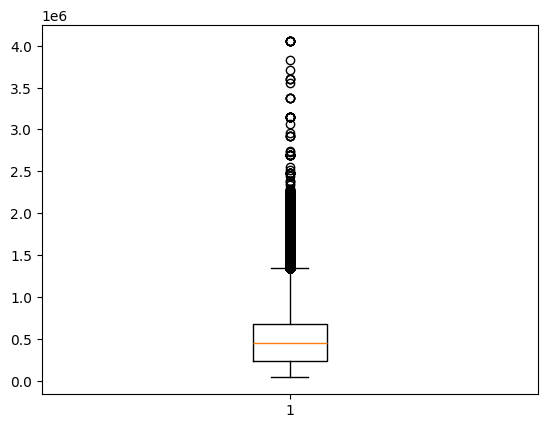

In [37]:
fig, ax = plt.subplots()

ax.boxplot(application_train["AMT_GOODS_PRICE"])

plt.show()

In [38]:
outliers_amt_good_price = count_outliers(application_train, "AMT_GOODS_PRICE")
print(f'Número de valores atípicos: {outliers_amt_good_price}')

Número de valores atípicos: 14728


In [39]:
application_train = remove_outliers_iteratively(application_train, 'AMT_GOODS_PRICE')

<h6><u>OCCUPATION_TYPE</u></h6>

In [40]:
application_train['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', nan, 'Drivers', 'Sales staff',
       'Cleaning staff', 'Cooking staff', 'Private service staff',
       'Managers', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries',
       'Accountants', 'IT staff', 'HR staff'], dtype=object)

In [41]:
application_train['OCCUPATION_TYPE'].fillna('Unemployed', inplace=True)

unique_values = application_train['OCCUPATION_TYPE'].unique()
print(unique_values)

['Laborers' 'Core staff' 'Unemployed' 'Drivers' 'Sales staff'
 'Cleaning staff' 'Cooking staff' 'Private service staff' 'Managers'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'Accountants' 'IT staff' 'HR staff']


In [42]:
application_train['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Pensioner', 'Commercial associate',
       'Unemployed', 'Student', 'Maternity leave', 'Businessman'],
      dtype=object)

In [43]:
application_train.loc[application_train['OCCUPATION_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Unemployed'


<h6><u>AMT_ANNUITY</u></h6>

In [44]:
mean_annuity = application_train['AMT_ANNUITY'].mean()

application_train['AMT_ANNUITY'].fillna(mean_annuity, inplace=True)

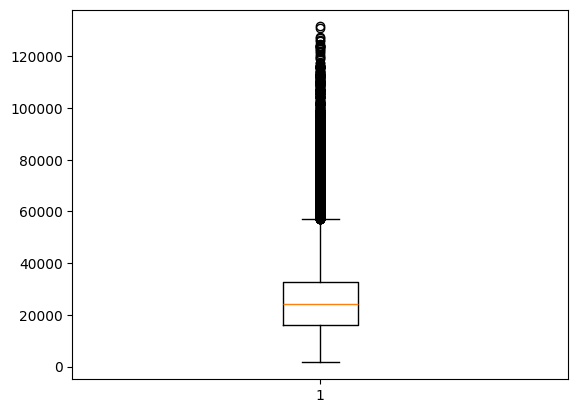

In [45]:
fig, ax = plt.subplots()

ax.boxplot(application_train["AMT_ANNUITY"])

plt.show()

In [46]:
outliers_amt_annuity = count_outliers(application_train, "AMT_ANNUITY")
print(f'Número de valores atípicos: {outliers_amt_annuity}')

Número de valores atípicos: 5272


In [47]:
application_train = remove_outliers_iteratively(application_train, 'AMT_ANNUITY')

<h6><u>AMT CREDIT</u></h6>

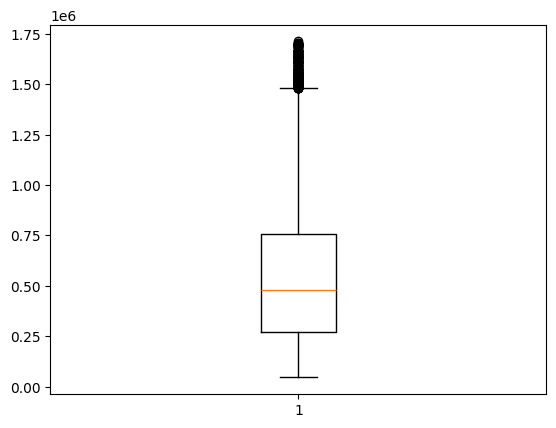

In [48]:
fig, ax = plt.subplots()

ax.boxplot(application_train["AMT_CREDIT"])

plt.show()

In [49]:
outliers_amt_credit = count_outliers(application_train, "AMT_CREDIT")
print(f'Número de valores atípicos: {outliers_amt_credit}')

Número de valores atípicos: 412


In [50]:
application_train = remove_outliers_iteratively(application_train, 'AMT_CREDIT')

<h6><u>DAYS EMPLOYED</u></h6>

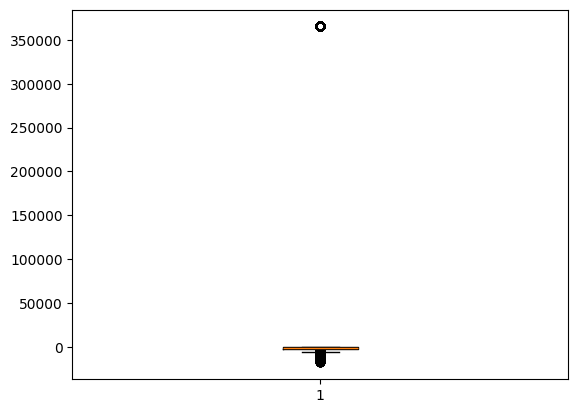

In [51]:
fig, ax = plt.subplots()

ax.boxplot(application_train["DAYS_EMPLOYED"])

plt.show()

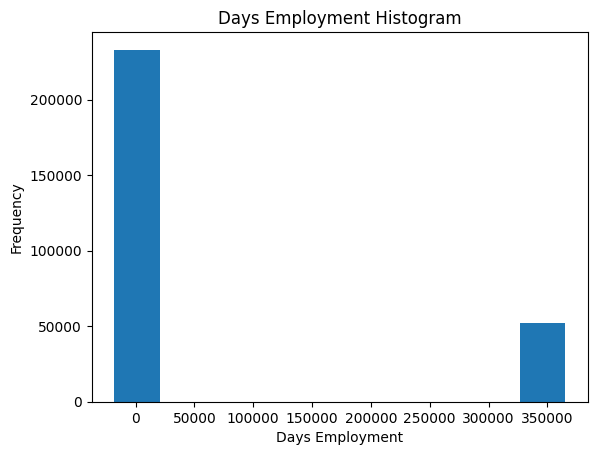

In [52]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [53]:
days_empl_out = application_train[application_train["DAYS_EMPLOYED"] == 365243]

In [54]:
days_empl_out.shape

(52402, 122)

In [55]:
user_counts_days = days_empl_out['TARGET'].value_counts()

percentage = days_empl_out['TARGET'].value_counts(normalize=True) * 100

result = pd.DataFrame({
    'Count': user_counts_days,
    'Percentage': percentage
})
result

,Count,Percentage
TARGET,,
0,49531,94.521201
1,2871,5.478799


In [56]:
application_train = application_train[application_train["DAYS_EMPLOYED"] != 365243]

In [57]:
application_train["DAYS_EMPLOYED"] = application_train["DAYS_EMPLOYED"].apply(lambda x: x * -1 if x < 0 else x)

In [58]:
application_train["DAYS_EMPLOYED"].describe()

count    233088.000000
mean       2356.848392
std        2325.554368
min           0.000000
25%         755.000000
50%        1621.000000
75%        3136.000000
max       17912.000000
Name: DAYS_EMPLOYED, dtype: float64

###### EXT_SOURCE_3

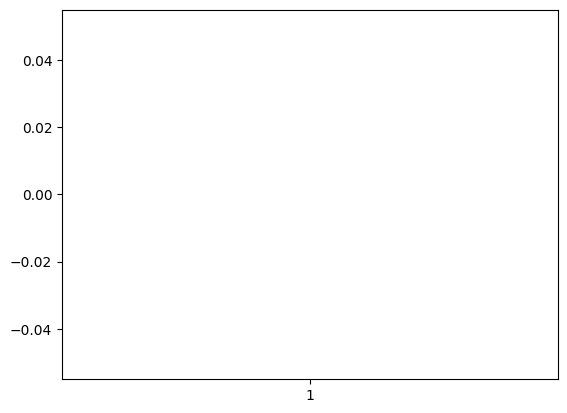

In [59]:
fig, ax = plt.subplots()

ax.boxplot(application_train["EXT_SOURCE_3"])

plt.show()

In [60]:
application_train = remove_outliers_iteratively(application_train, 'EXT_SOURCE_3')

###### EXT_SOURCE_2

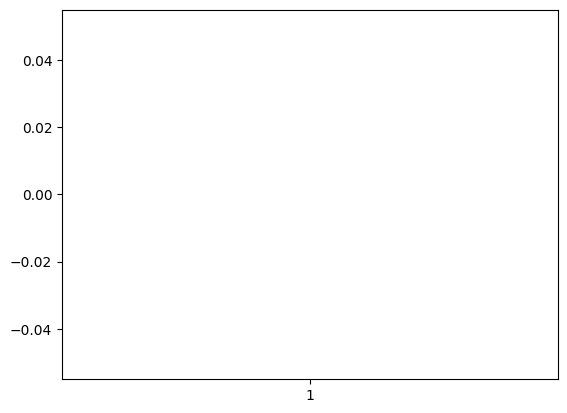

In [61]:
fig, ax = plt.subplots()

ax.boxplot(application_train["EXT_SOURCE_2"])

plt.show()

In [62]:
application_train = remove_outliers_iteratively(application_train, 'EXT_SOURCE_2')

###### EXT_SOURCE_1 

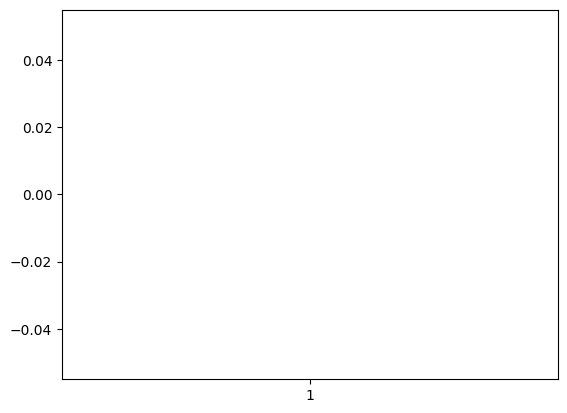

In [63]:
fig, ax = plt.subplots()

ax.boxplot(application_train["EXT_SOURCE_1"])

plt.show()

In [64]:
application_train = remove_outliers_iteratively(application_train, 'EXT_SOURCE_1')

##### FLAG_OWN_CAR - OWN_CAR_AGE

In [65]:
mean_car_age = application_train.loc[application_train['FLAG_OWN_CAR'] == 'Y', 'OWN_CAR_AGE'].mean()

application_train['OWN_CAR_AGE'] = application_train.apply(lambda x: mean_car_age if pd.isnull(x['OWN_CAR_AGE']) and x['FLAG_OWN_CAR'] == 'Y' else 0, axis=1)

nan_count = application_train['OWN_CAR_AGE'].isnull().sum()
print("Number of NaN values after replacement:", nan_count)

Number of NaN values after replacement: 0


##### EXT_SOURCE

In [66]:
knn_imputer = KNNImputer()

In [67]:
application_train['EXT_SOURCE_1'].fillna(0, inplace=True)

application_train['EXT_SOURCE_2'] = knn_imputer.fit_transform(application_train[['EXT_SOURCE_2']])

application_train['EXT_SOURCE_3'] = knn_imputer.fit_transform(application_train[['EXT_SOURCE_3']])

##### Bureau

In [68]:
contar_valores_nulos_con_porcentaje(bureau)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_CURR,0,0.000000
SK_ID_BUREAU,0,0.000000
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000
CREDIT_DAY_OVERDUE,0,0.000000
DAYS_CREDIT_ENDDATE,105553,6.149573
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
CNT_CREDIT_PROLONG,0,0.000000


In [69]:
bureau.loc[bureau['CREDIT_ACTIVE'] == 'Active', 'DAYS_ENDDATE_FACT'] = 0

##### Pos Cash Balance

In [70]:
contar_valores_nulos_con_porcentaje(pos_cash_balance)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
CNT_INSTALMENT,26071,0.260675
CNT_INSTALMENT_FUTURE,26087,0.260835
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


In [71]:
pos_cash_balance = pos_cash_balance.dropna(subset=['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE'])

##### Credit Card Balance

In [72]:
contar_valores_nulos_con_porcentaje(credit_card_balance)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
AMT_BALANCE,0,0.000000
AMT_CREDIT_LIMIT_ACTUAL,0,0.000000
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_CURRENT,0,0.000000
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_INST_MIN_REGULARITY,305236,7.948208


In [73]:
credit_card_balance.fillna(0, inplace=True)

##### Installments Payments

In [74]:
contar_valores_nulos_con_porcentaje(installments_payments)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_INSTALMENT,0,0.000000
AMT_PAYMENT,2905,0.021352


In [75]:
installments_payments = installments_payments.dropna(subset=['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT'])

<div id="transformaciondedatos" style="text-align: center;">
    <h3><u>Transformación de Datos</u></h3>
</div>

#### Application Train / Test

In [76]:
label_encoder = LabelEncoder()

application_train['FLAG_OWN_CAR_ENCODED'] = label_encoder.fit_transform(application_train['FLAG_OWN_CAR'])
application_train['FLAG_OWN_REALTY_ENCODED'] = label_encoder.fit_transform(application_train['FLAG_OWN_REALTY'])

In [77]:
application_train['tiene_hijos'] = application_train['CNT_CHILDREN'].apply(lambda x: 1 if x > 0 else 0)
#application_test['tiene_hijos'] = application_test['CNT_CHILDREN'].apply(lambda x: 1 if x > 0 else 0)

In [78]:
columns_to_encode = ["NAME_INCOME_TYPE", "NAME_CONTRACT_TYPE" , "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]

label_encoder = LabelEncoder()

for col in columns_to_encode:
    label_encoder.fit(pd.concat([application_train[col]]))

    application_train[col + '_encoded'] = label_encoder.transform(application_train[col])

In [79]:
application_train.fillna(0, inplace=True)
#application_test.fillna(0, inplace=True)

#### Bureau

In [80]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,0.0,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,0.0,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,0.0,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,0.0,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,0.0,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [81]:
bureau.fillna(0, inplace=True)

In [82]:
aggregations = {
    'DAYS_CREDIT': 'min',
    'CREDIT_DAY_OVERDUE': 'mean',
    'AMT_CREDIT_MAX_OVERDUE': 'max',
    'CNT_CREDIT_PROLONG': 'max',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum'
}

new_bureau = bureau.groupby(['SK_ID_CURR', 'SK_ID_BUREAU']).agg(aggregations)

new_bureau.reset_index(inplace=True)

#### Bureau Balance

In [83]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [84]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [85]:
grouped_status_counts = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts()

grouped_status_counts = grouped_status_counts.reset_index()

In [86]:
grouped_status_counts.head()

,SK_ID_BUREAU,STATUS,count
0,5001709,C,86
1,5001709,X,11
2,5001710,C,48
3,5001710,X,30
4,5001710,0,5


In [87]:
pivot_table = pd.pivot_table(grouped_status_counts, index='SK_ID_BUREAU', columns='STATUS', fill_value=0)

pivot_table = pivot_table.reset_index()
pivot_table

SK_ID_BUREAU count                                      
STATUS                  0    1    2    3    4     5     C     X
0           5001709   0.0  0.0  0.0  0.0  0.0   0.0  86.0  11.0
1           5001710   5.0  0.0  0.0  0.0  0.0   0.0  48.0  30.0
2           5001711   3.0  0.0  0.0  0.0  0.0   0.0   0.0   1.0
3           5001712  10.0  0.0  0.0  0.0  0.0   0.0   9.0   0.0
4           5001713   0.0  0.0  0.0  0.0  0.0   0.0   0.0  22.0
...             ...   ...  ...  ...  ...  ...   ...   ...   ...
817390      6842884   9.0  0.0  0.0  0.0  0.0   0.0  20.0  19.0
817391      6842885  12.0  0.0  0.0  0.0  0.0  12.0   0.0   0.0
817392      6842886   8.0  0.0  0.0  0.0  0.0   0.0  25.0   0.0
817393      6842887   6.0  0.0  0.0  0.0  0.0   0.0  31.0   0.0
817394      6842888   9.0  1.0  0.0  0.0  0.0   0.0  52.0   0.0

[817395 rows x 9 columns]

In [88]:
pivot_table.dtypes

              STATUS
SK_ID_BUREAU              int64
count         0         float64
              1         float64
              2         float64
              3         float64
              4         float64
              5         float64
              C         float64
              X         float64
dtype: object

In [89]:
pivot_table

SK_ID_BUREAU count                                      
STATUS                  0    1    2    3    4     5     C     X
0           5001709   0.0  0.0  0.0  0.0  0.0   0.0  86.0  11.0
1           5001710   5.0  0.0  0.0  0.0  0.0   0.0  48.0  30.0
2           5001711   3.0  0.0  0.0  0.0  0.0   0.0   0.0   1.0
3           5001712  10.0  0.0  0.0  0.0  0.0   0.0   9.0   0.0
4           5001713   0.0  0.0  0.0  0.0  0.0   0.0   0.0  22.0
...             ...   ...  ...  ...  ...  ...   ...   ...   ...
817390      6842884   9.0  0.0  0.0  0.0  0.0   0.0  20.0  19.0
817391      6842885  12.0  0.0  0.0  0.0  0.0  12.0   0.0   0.0
817392      6842886   8.0  0.0  0.0  0.0  0.0   0.0  25.0   0.0
817393      6842887   6.0  0.0  0.0  0.0  0.0   0.0  31.0   0.0
817394      6842888   9.0  1.0  0.0  0.0  0.0   0.0  52.0   0.0

[817395 rows x 9 columns]

In [90]:
pivot_table.columns = ['count_' + '_'.join(col) for col in pivot_table.columns]

In [91]:
pivot_table = pivot_table.rename(columns={'count_SK_ID_BUREAU_': 'SK_ID_BUREAU'})

In [92]:
pivot_table.dtypes

SK_ID_BUREAU       int64
count_count_0    float64
count_count_1    float64
count_count_2    float64
count_count_3    float64
count_count_4    float64
count_count_5    float64
count_count_C    float64
count_count_X    float64
dtype: object

#### Credit_card_balance

In [93]:
aggregations = {
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_POS_CURRENT': 'mean'
}

new_credit_card_balance = credit_card_balance.groupby('SK_ID_CURR').agg(aggregations)

new_credit_card_balance.reset_index(inplace=True)

#### Pos_cash_balance

In [94]:
label_encoder = LabelEncoder()

pos_cash_balance['NAME_CONTRACT_STATUS_ENCODED'] = label_encoder.fit_transform(pos_cash_balance['NAME_CONTRACT_STATUS'])

In [95]:
pos_cash_balance_grouped = pos_cash_balance.groupby('SK_ID_CURR').agg({'SK_DPD': 'mean', 'SK_DPD_DEF': 'mean', 'CNT_INSTALMENT_FUTURE': 'sum'}).reset_index()

pos_cash_balance_grouped.rename(columns={'SK_DPD': 'mean_SK_DPD', 'SK_DPD_DEF': 'mean_SK_DPD_DEF', 'CNT_INSTALMENT_FUTURE': 'sum_CNT_INSTALMENT_FUTURE'}, inplace=True)

pos_cash_balance_grouped

,SK_ID_CURR,mean_SK_DPD,mean_SK_DPD_DEF,sum_CNT_INSTALMENT_FUTURE
0,100001,0.777778,0.777778,13.0
1,100002,0.000000,0.000000,285.0
2,100003,0.000000,0.000000,162.0
3,100004,0.000000,0.000000,9.0
4,100005,0.000000,0.000000,72.0
...,...,...,...,...
337219,456251,0.000000,0.000000,35.0
337220,456252,0.000000,0.000000,21.0
337221,456253,0.294118,0.294118,34.0
337222,456254,0.000000,0.000000,207.0


#### Installments_payments

In [96]:
installments_payments.shape

(13602496, 8)

In [97]:
installments_payments['DIFF_DAYS_PAYMENT'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']

In [98]:
installments_payments['DIFF_AMT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

In [99]:
installments_payments_grouped = installments_payments.groupby('SK_ID_CURR').agg({'DIFF_DAYS_PAYMENT': 'mean', 'DIFF_AMT': 'mean'}).reset_index()

<div id="exploraciondedatos" style="text-align: center;">
    <h2><u>Exploración de Datos</u></h2>
</div>

In [100]:
X_train = pd.merge(application_train, new_bureau, on='SK_ID_CURR', how='left')

In [101]:
X_train = pd.merge(X_train, pivot_table, on='SK_ID_BUREAU', how='left')

In [102]:
X_train = pd.merge(X_train, pos_cash_balance_grouped, on='SK_ID_CURR', how='left')

In [103]:
X_train = pd.merge(X_train, installments_payments_grouped, on='SK_ID_CURR', how='left')

In [104]:
X_train = pd.merge(X_train, new_credit_card_balance, on='SK_ID_CURR', how='left')

In [95]:
# X_train.drop(columns=['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
#                       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
#                       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
#                       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE'], inplace=True)


###### NAME FAMILY STATUS

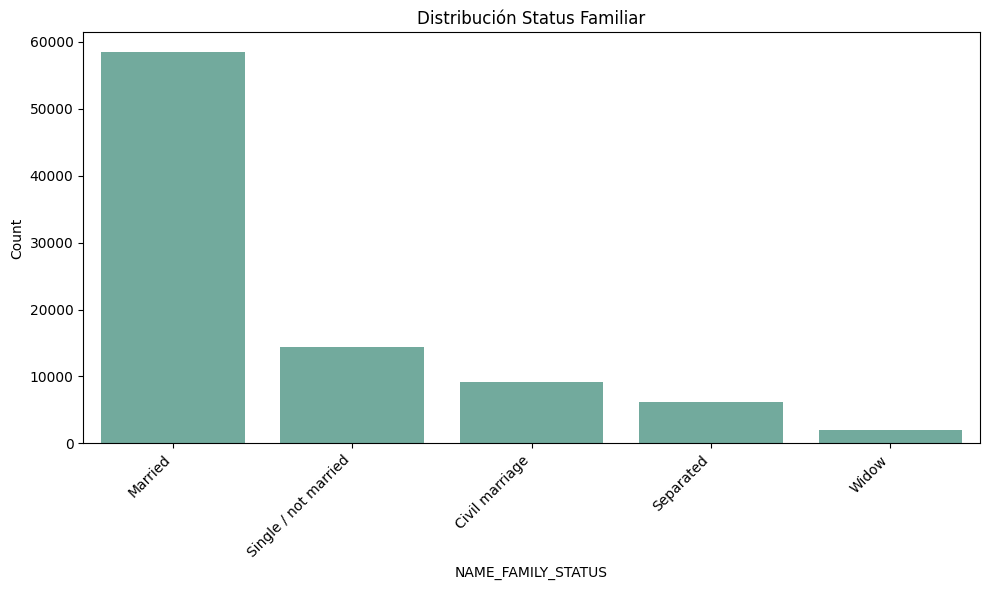

In [109]:
# Se analiza la distribución de los registros (clientes) y su status familiar.
family_status_counts = application_train['NAME_FAMILY_STATUS'].value_counts().reset_index()
family_status_counts.columns = ['NAME_FAMILY_STATUS', 'Count']

plt.figure(figsize=(10, 6))

sns.barplot(
    x='NAME_FAMILY_STATUS', 
    y='Count', 
    data=family_status_counts, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
)

plt.xticks(rotation=45, ha='right')
plt.title('Distribución Status Familiar')
plt.xlabel('NAME_FAMILY_STATUS')
plt.ylabel('Count')

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()

plt.show()

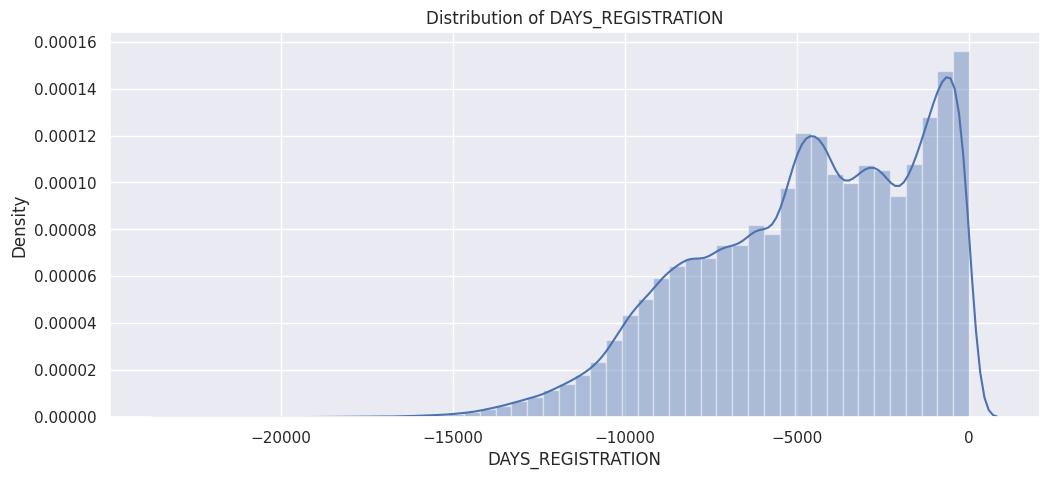

In [137]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_REGISTRATION")
ax = sns.distplot(application_train["DAYS_REGISTRATION"])

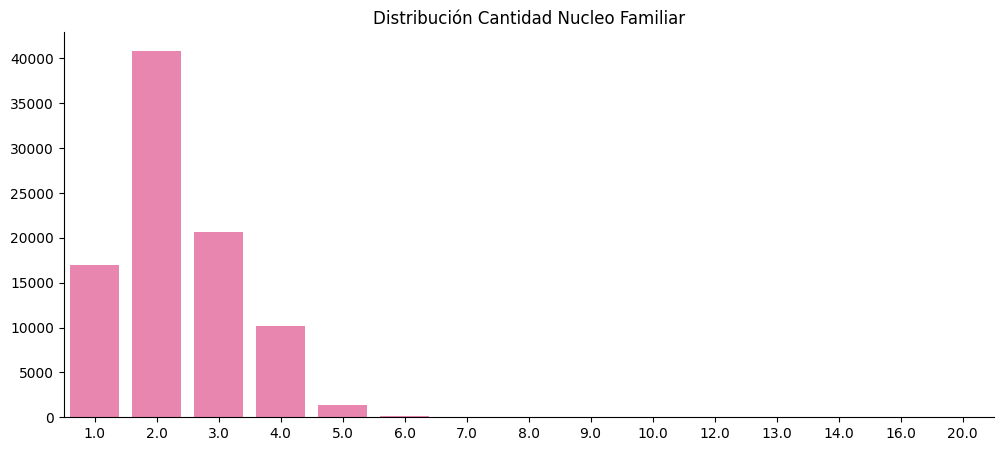

In [110]:
t = application_train["CNT_FAM_MEMBERS"].value_counts()
t1 = pd.DataFrame()
t1['x'] = t.index 
t1['y'] = t.values 

plt.figure(figsize=(12,5));
plt.title("Distribución Cantidad Nucleo Familiar");
ax = sns.barplot(data=t1, x="x", y="y", color="#f975ae");
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);

ax.set_ylabel('');    
ax.set_xlabel('');

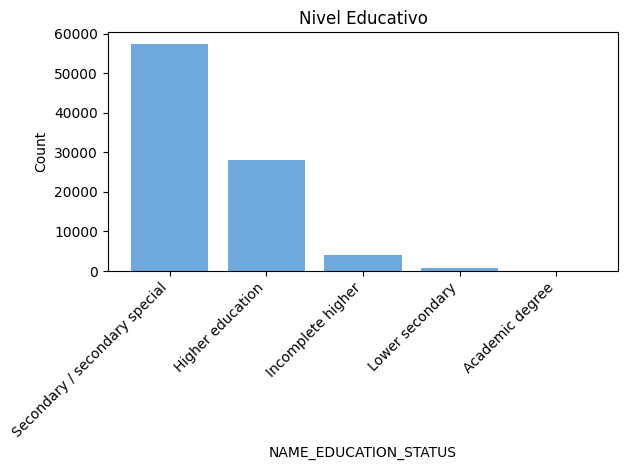

In [111]:
education_status_counts = application_train['NAME_EDUCATION_TYPE'].value_counts()

y_pos = range(len(education_status_counts))
height = education_status_counts.values

plt.bar(y_pos, height, color='#6fa8dc')

plt.xticks(y_pos, education_status_counts.index, rotation=45, ha='right')

plt.title('Nivel Educativo')
plt.xlabel('NAME_EDUCATION_STATUS')
plt.ylabel('Count')

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()
plt.show()

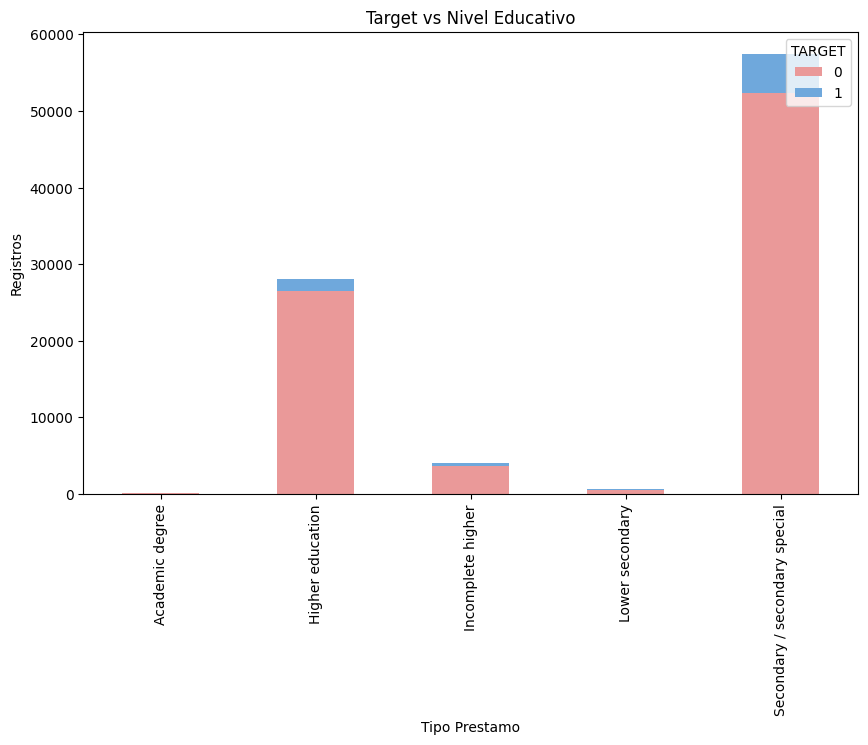

In [112]:
educ_table = pd.crosstab(application_train['NAME_EDUCATION_TYPE'], application_train['TARGET'])

educ_table.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ea9999', '#6fa8dc'])
plt.title('Target vs Nivel Educativo')
plt.xlabel('Tipo Prestamo')
plt.ylabel('Registros')
plt.legend(title='TARGET', loc='upper right')
plt.show()

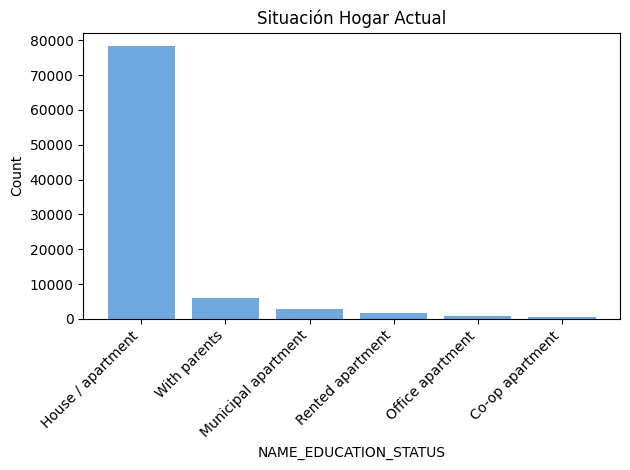

In [113]:
housing_status_counts = application_train['NAME_HOUSING_TYPE'].value_counts()

y_pos = range(len(housing_status_counts))
height = housing_status_counts.values

plt.bar(y_pos, height, color='#6fa8dc')

plt.xticks(y_pos, housing_status_counts.index, rotation=45, ha='right')

plt.title('Situación Hogar Actual')
plt.xlabel('NAME_EDUCATION_STATUS')
plt.ylabel('Count')

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()
plt.show()

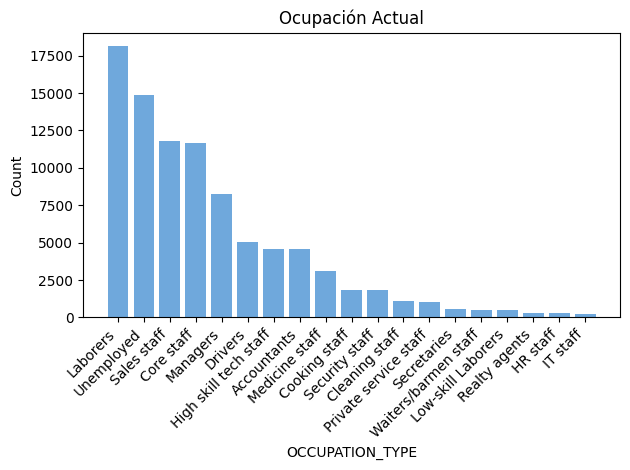

In [114]:
occupation_type_counts = application_train['OCCUPATION_TYPE'].value_counts()

y_pos = range(len(occupation_type_counts))
height = occupation_type_counts.values

plt.bar(y_pos, height, color='#6fa8dc')

plt.xticks(y_pos, occupation_type_counts.index, rotation=45, ha='right')

plt.title('Ocupación Actual')
plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('Count')

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()
plt.show()

##### Target

El siguiente grafico muestra datos desbalanceados en el dataset de application_train. Esto puede generar complejidades al momento de entrenar el modelo.

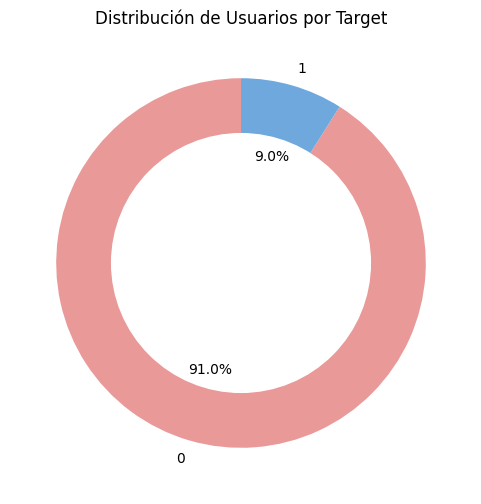

In [98]:
user_counts = application_train['TARGET'].value_counts()

sizes = user_counts.values
labels = user_counts.index

colors = ['#ea9999', '#6fa8dc'] 

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Distribución de Usuarios por Target')

plt.show()

In [99]:
user_counts = application_train['TARGET'].value_counts()
user_counts

TARGET
0    212212
1     20876
Name: count, dtype: int64

##### Name Contract Type

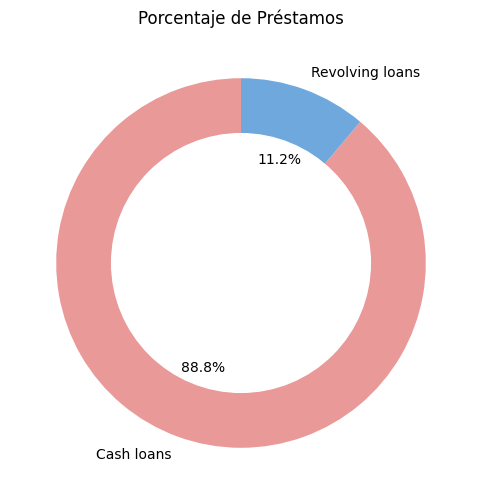

In [116]:
contract_type_counts = application_train['NAME_CONTRACT_TYPE'].value_counts()

sizes = contract_type_counts.values
labels = contract_type_counts.index

colors = ['#ea9999', '#6fa8dc']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Porcentaje de Préstamos')

plt.show()

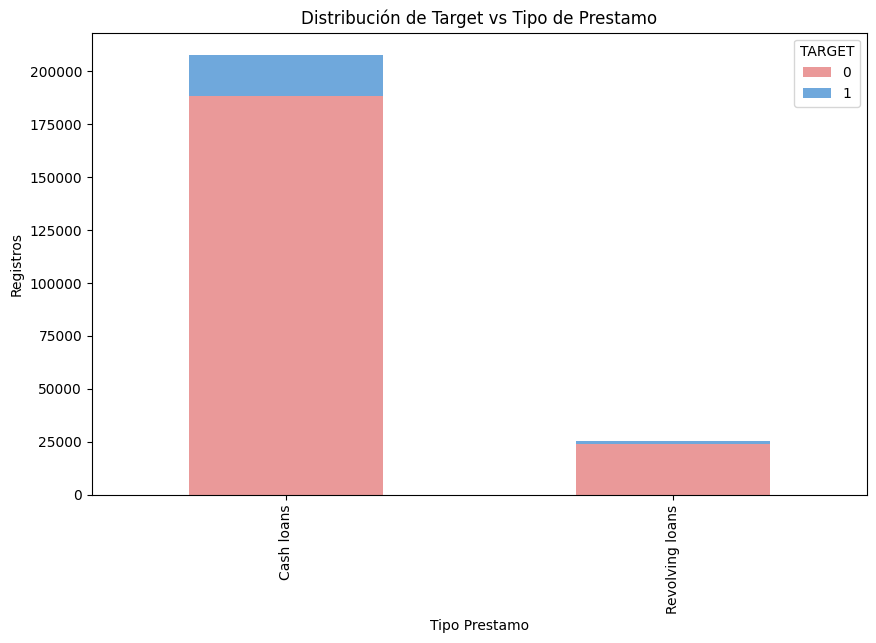

In [102]:
contingency_table = pd.crosstab(application_train['NAME_CONTRACT_TYPE'], application_train['TARGET'])

contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ea9999', '#6fa8dc'])
plt.title('Distribución de Target vs Tipo de Prestamo')
plt.xlabel('Tipo Prestamo')
plt.ylabel('Registros')
plt.legend(title='TARGET', loc='upper right')
plt.show()

In [103]:
# Indica la cantidad de tipos de prestamos y el porcentaje correspondiente.
contingency_table

TARGET,0,1
NAME_CONTRACT_TYPE,,
Cash loans,188329,19415
Revolving loans,23883,1461


##### NAME_INCOME_TYPE

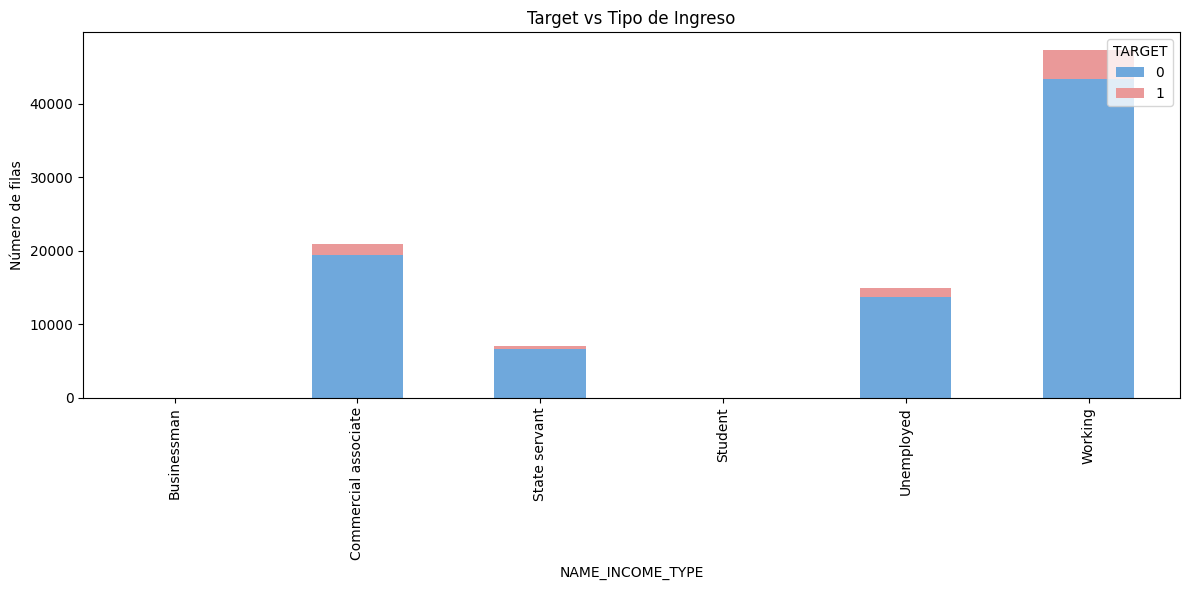

In [118]:
contingency_table = pd.crosstab(application_train['NAME_INCOME_TYPE'], application_train['TARGET'])

contingency_table.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#6fa8dc', '#ea9999'])
plt.title('Target vs Tipo de Ingreso')
plt.xlabel('NAME_INCOME_TYPE')
plt.ylabel('Número de filas')
plt.legend(title='TARGET', loc='upper right')

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()

##### FLAG_OWN_CAR & FLAG_OWN_REALTY

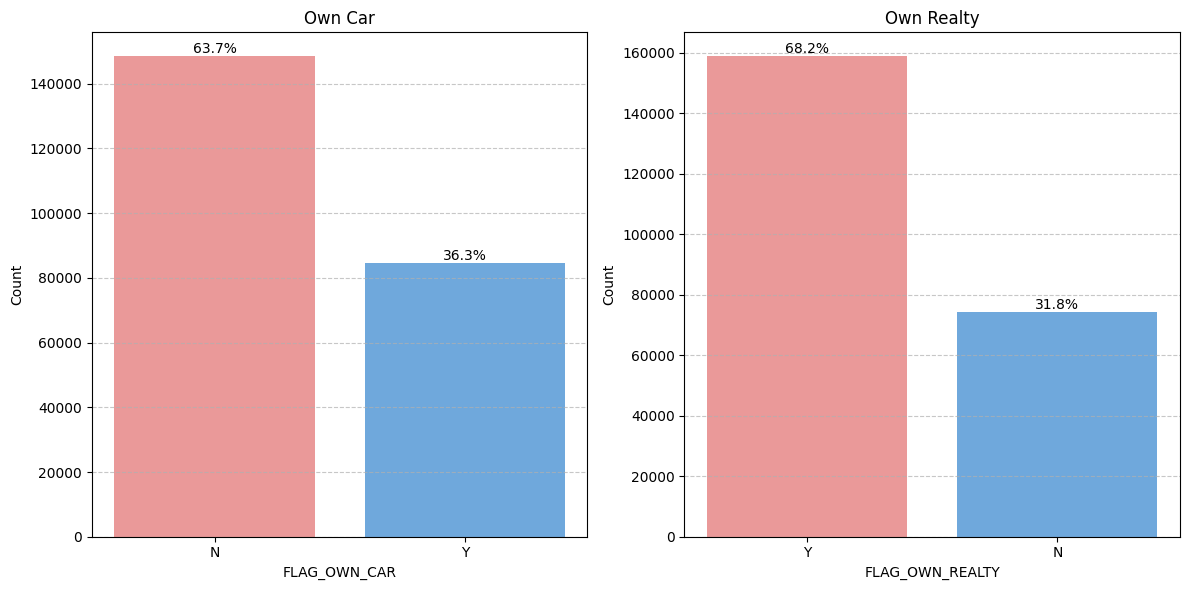

In [104]:
temp1 = application_train["FLAG_OWN_CAR"].value_counts()
temp2 = application_train["FLAG_OWN_REALTY"].value_counts()

total_temp1 = temp1.sum()
total_temp2 = temp2.sum()
percent_temp1 = [(count / total_temp1) * 100 for count in temp1.values]
percent_temp2 = [(count / total_temp2) * 100 for count in temp2.values]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

bars1 = axs[0].bar(temp1.index, temp1.values, color=['#ea9999', '#6fa8dc'])
axs[0].set_title('Own Car')
axs[0].set_xlabel('FLAG_OWN_CAR')
axs[0].set_ylabel('Count')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

bars2 = axs[1].bar(temp2.index, temp2.values, color=['#ea9999', '#6fa8dc'])
axs[1].set_title('Own Realty')
axs[1].set_xlabel('FLAG_OWN_REALTY')
axs[1].set_ylabel('Count')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

def add_percentage_labels(ax, bars, percentages):
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 100, f'{percent:.1f}%', ha='center', va='bottom')

add_percentage_labels(axs[0], bars1, percent_temp1)
add_percentage_labels(axs[1], bars2, percent_temp2)

plt.tight_layout()

plt.show()

###### EXT_SOURCE_3

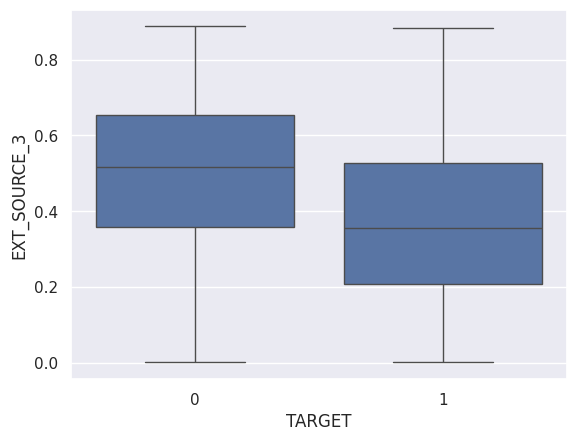

In [119]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=application_train["TARGET"], y=application_train["EXT_SOURCE_3"])
plt.show()

###### EXT_SOURCE_2

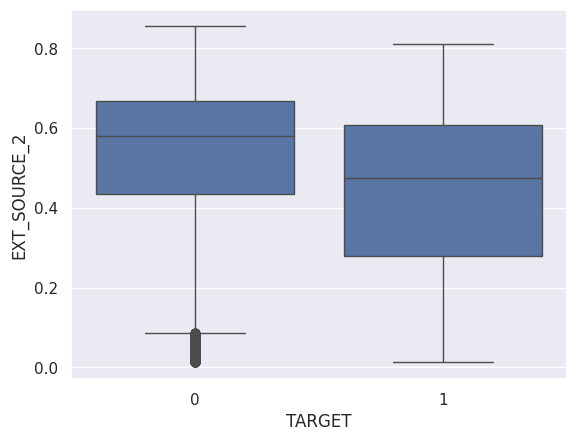

In [120]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=application_train["TARGET"], y=application_train["EXT_SOURCE_2"])
plt.show()

###### EXT_SOURCE_1

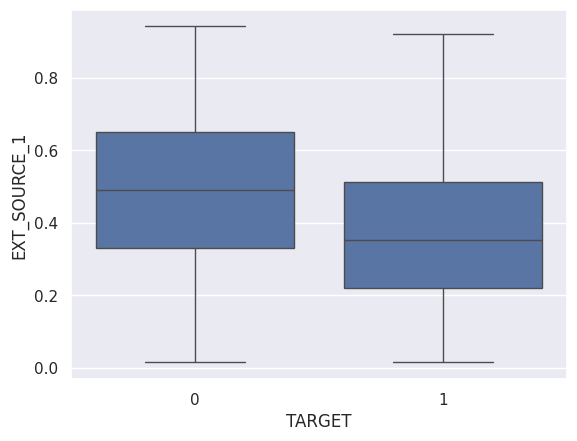

In [121]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=application_train["TARGET"], y=application_train["EXT_SOURCE_1"])
plt.show()

##### DAYS_EMPLOYED

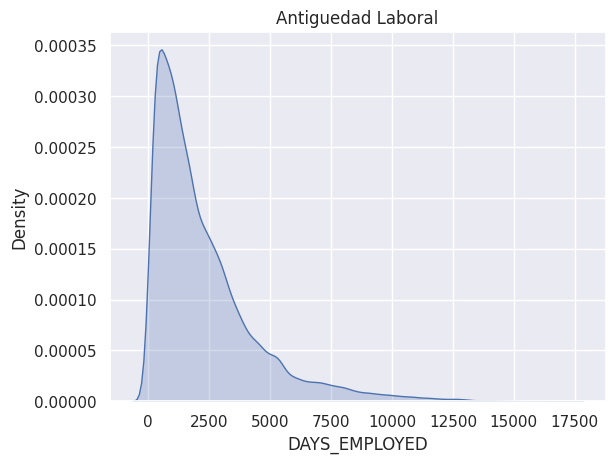

In [126]:
sns.set_theme(style="darkgrid")
sns.kdeplot(application_train["DAYS_EMPLOYED"], fill=True)
plt.title("Antiguedad Laboral")
plt.show()

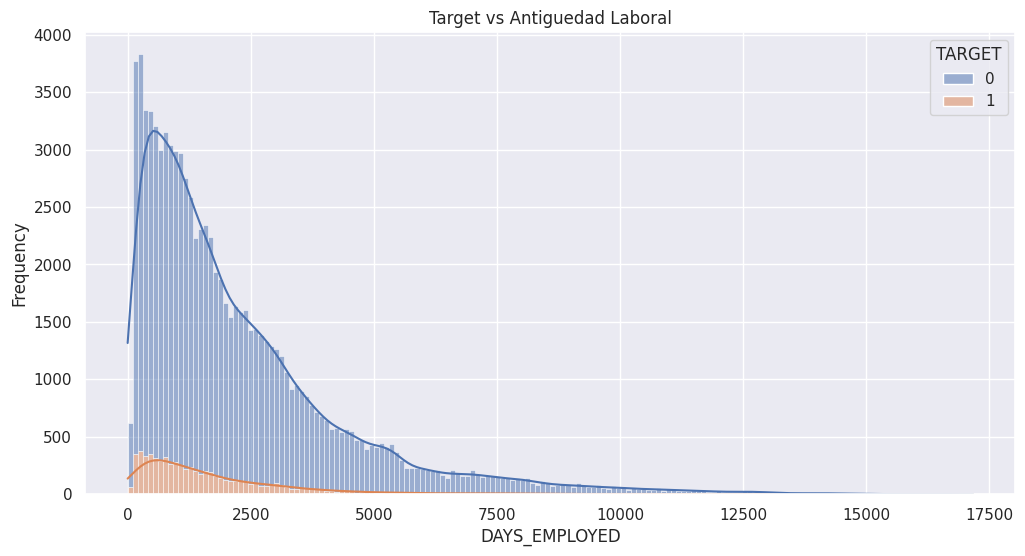

In [125]:
plt.figure(figsize=(12, 6))
sns.histplot(data=application_train, x="DAYS_EMPLOYED", hue="TARGET", multiple="stack", kde=True)
plt.title("Target vs Antiguedad Laboral")
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel("Frequency")
plt.show()

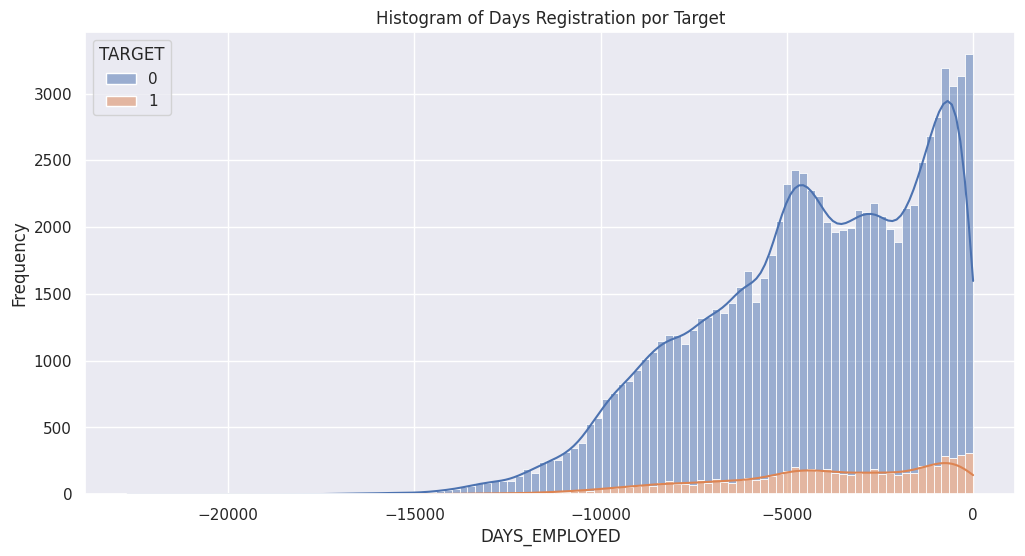

In [127]:
plt.figure(figsize=(12, 6))
sns.histplot(data=application_train, x="DAYS_REGISTRATION", hue="TARGET", multiple="stack", kde=True)
plt.title("Histogram of Days Registration por Target")
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel("Frequency")
plt.show()

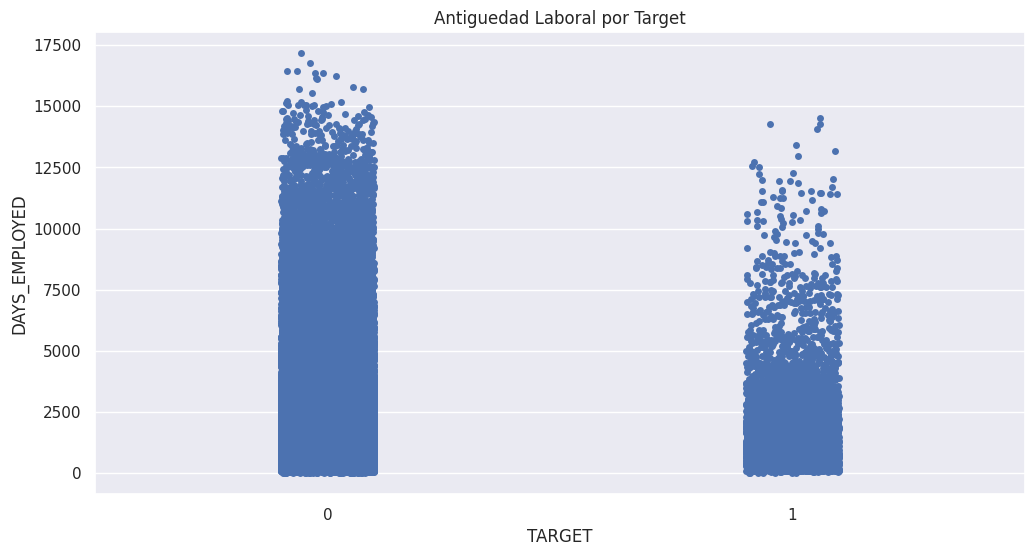

In [128]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=application_train, x="TARGET", y="DAYS_EMPLOYED", jitter=True)
plt.title("Antiguedad Laboral por Target")
plt.xlabel("TARGET")
plt.ylabel("DAYS_EMPLOYED")
plt.show()


##### AMT CREDIT

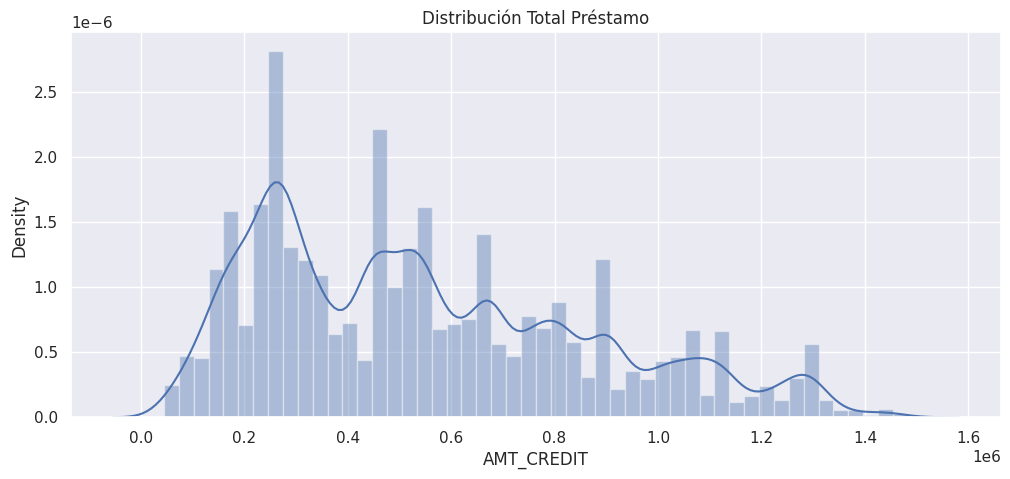

In [129]:
plt.figure(figsize=(12, 5))
plt.title("Distribución Total Préstamo")
ax = sns.distplot(application_train['AMT_CREDIT'])
plt.show()

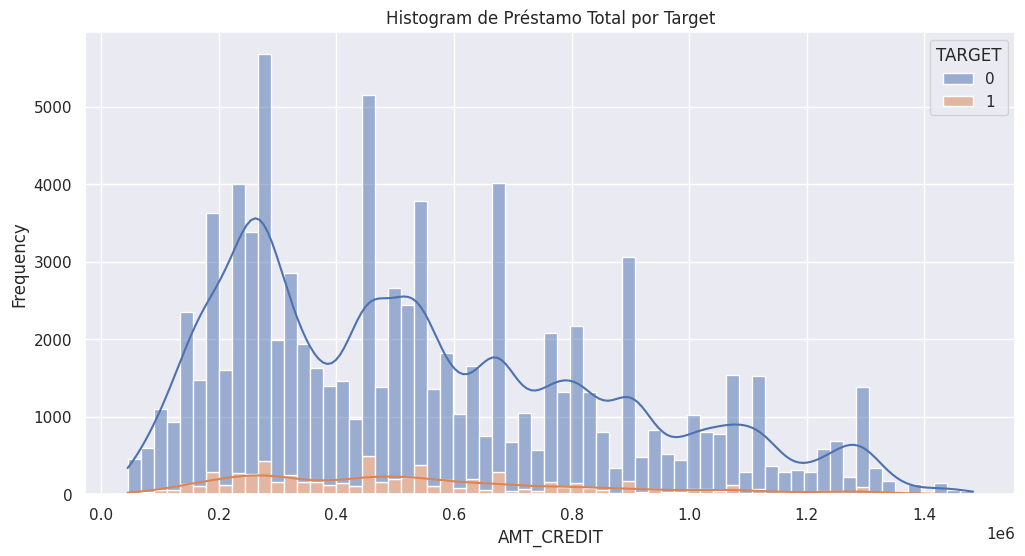

In [133]:
plt.figure(figsize=(12, 6))
sns.histplot(data=application_train, x="AMT_CREDIT", hue="TARGET", multiple="stack", kde=True)
plt.title("Histogram de Préstamo Total por Target")
plt.xlabel("AMT_CREDIT")
plt.ylabel("Frequency")
plt.show()

##### AMT CREDIT

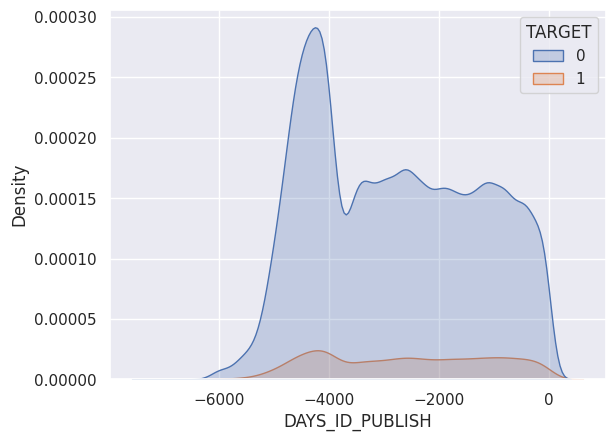

In [106]:
sns.set_theme(style="darkgrid")

sns.kdeplot(data=application_train, x="DAYS_ID_PUBLISH", hue="TARGET", fill=True)

plt.show()

##### DAYS_BIRTH

In [107]:
application_train['Edad'] = (application_train['DAYS_BIRTH'] / -365)

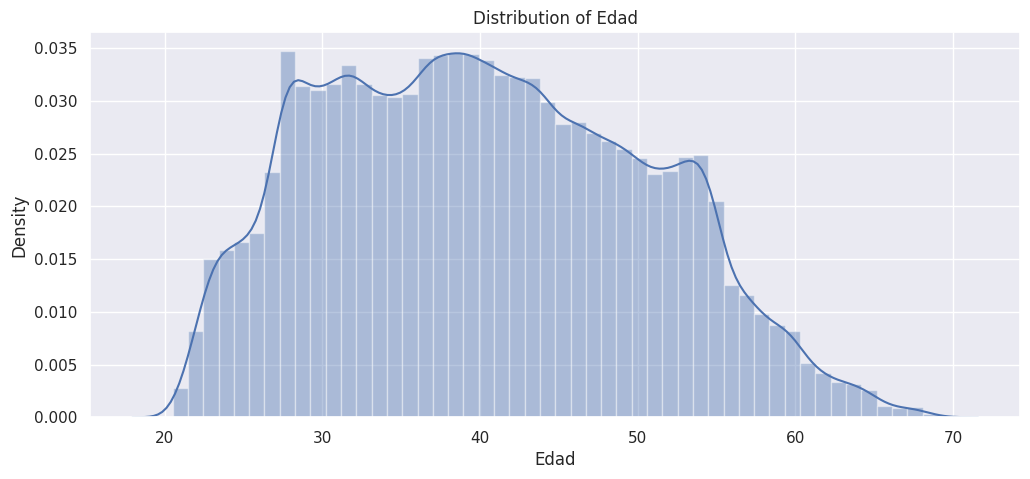

In [108]:
plt.figure(figsize=(12, 5))
plt.title("Distribution of Edad")
ax = sns.distplot(application_train['Edad'])
plt.show()

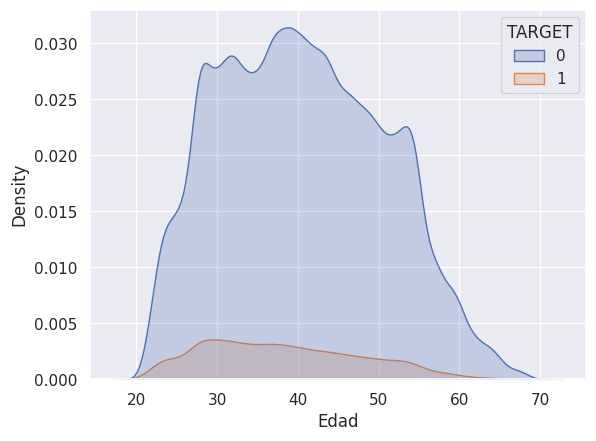

In [109]:
sns.set_theme(style="darkgrid")

sns.kdeplot(data=application_train, x="Edad", hue="TARGET", fill=True)

plt.show()

In [106]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    233088.000000
mean         40.302791
std          10.054941
min          20.517808
25%          32.046575
50%          39.736986
75%          47.983562
max          69.041096
Name: DAYS_BIRTH, dtype: float64

##### AMT_GOODS_PRICE 

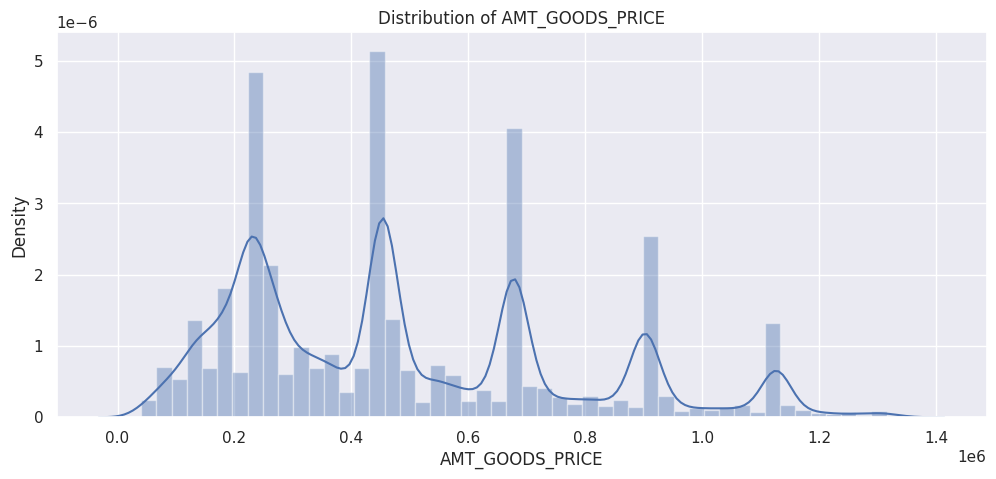

In [127]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

##### AMT_REQ_CREDIT_BUREAU_MON

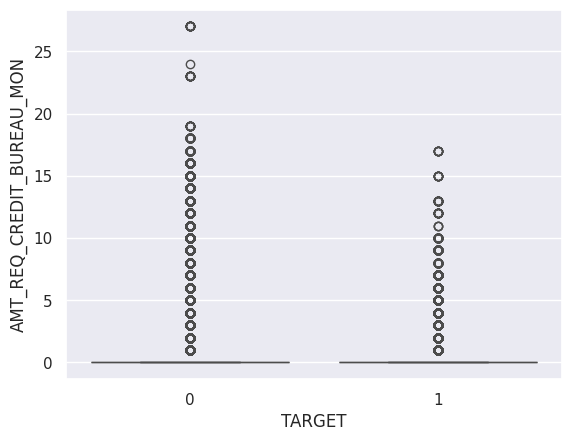

In [124]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["AMT_REQ_CREDIT_BUREAU_MON"])
plt.show()

##### AMT_REQ_CREDIT_BUREAU_WEEK

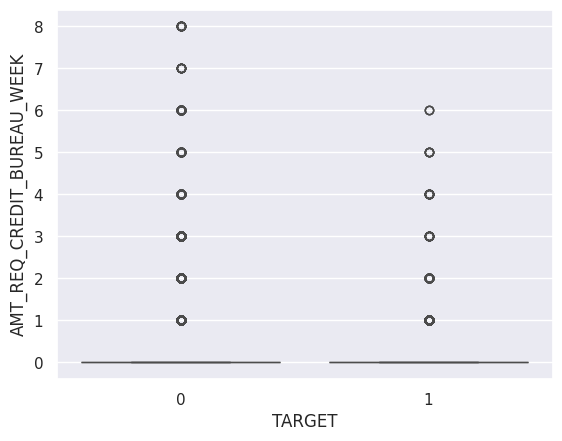

In [125]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["AMT_REQ_CREDIT_BUREAU_WEEK"])
plt.show()

###### AMT_REQ_CREDIT_BUREAU_QRT 

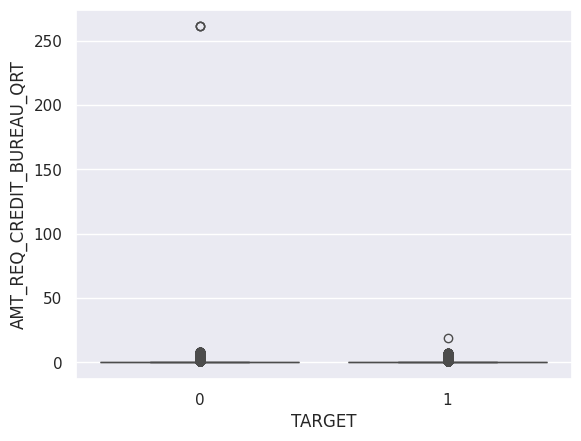

In [126]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["AMT_REQ_CREDIT_BUREAU_QRT"])
plt.show()

###### AMT_REQ_CREDIT_BUREAU_YEAR

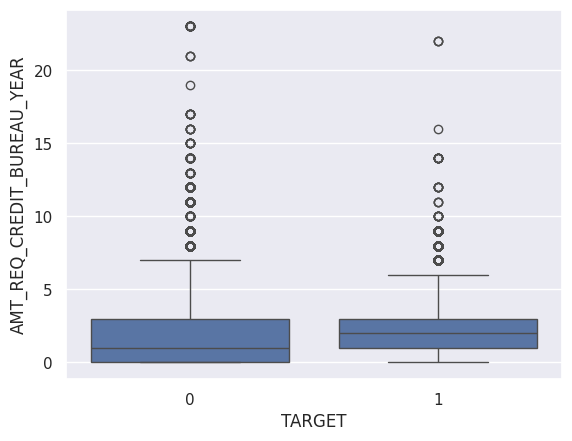

In [123]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["AMT_REQ_CREDIT_BUREAU_YEAR"])
plt.show()

##### CNT_INSTALMENT_FUTURE

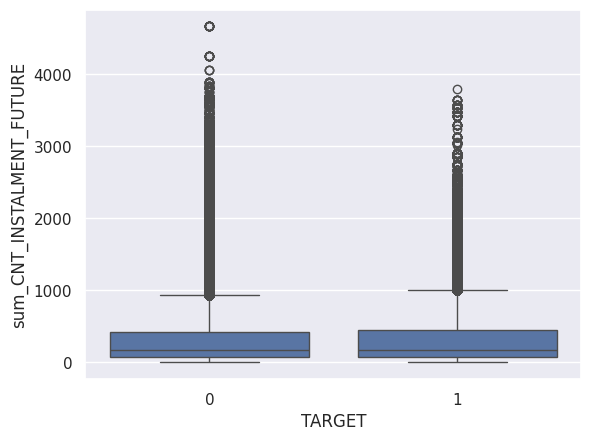

In [144]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["sum_CNT_INSTALMENT_FUTURE"])
plt.show()


###### DIFF_AMT 

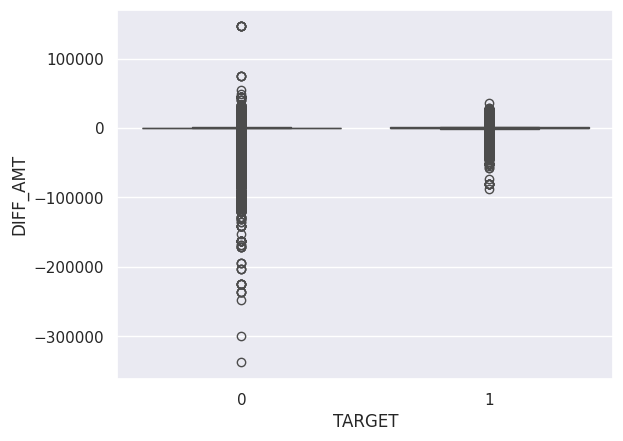

In [146]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=X_train["TARGET"], y=X_train["DIFF_AMT"])
plt.show()

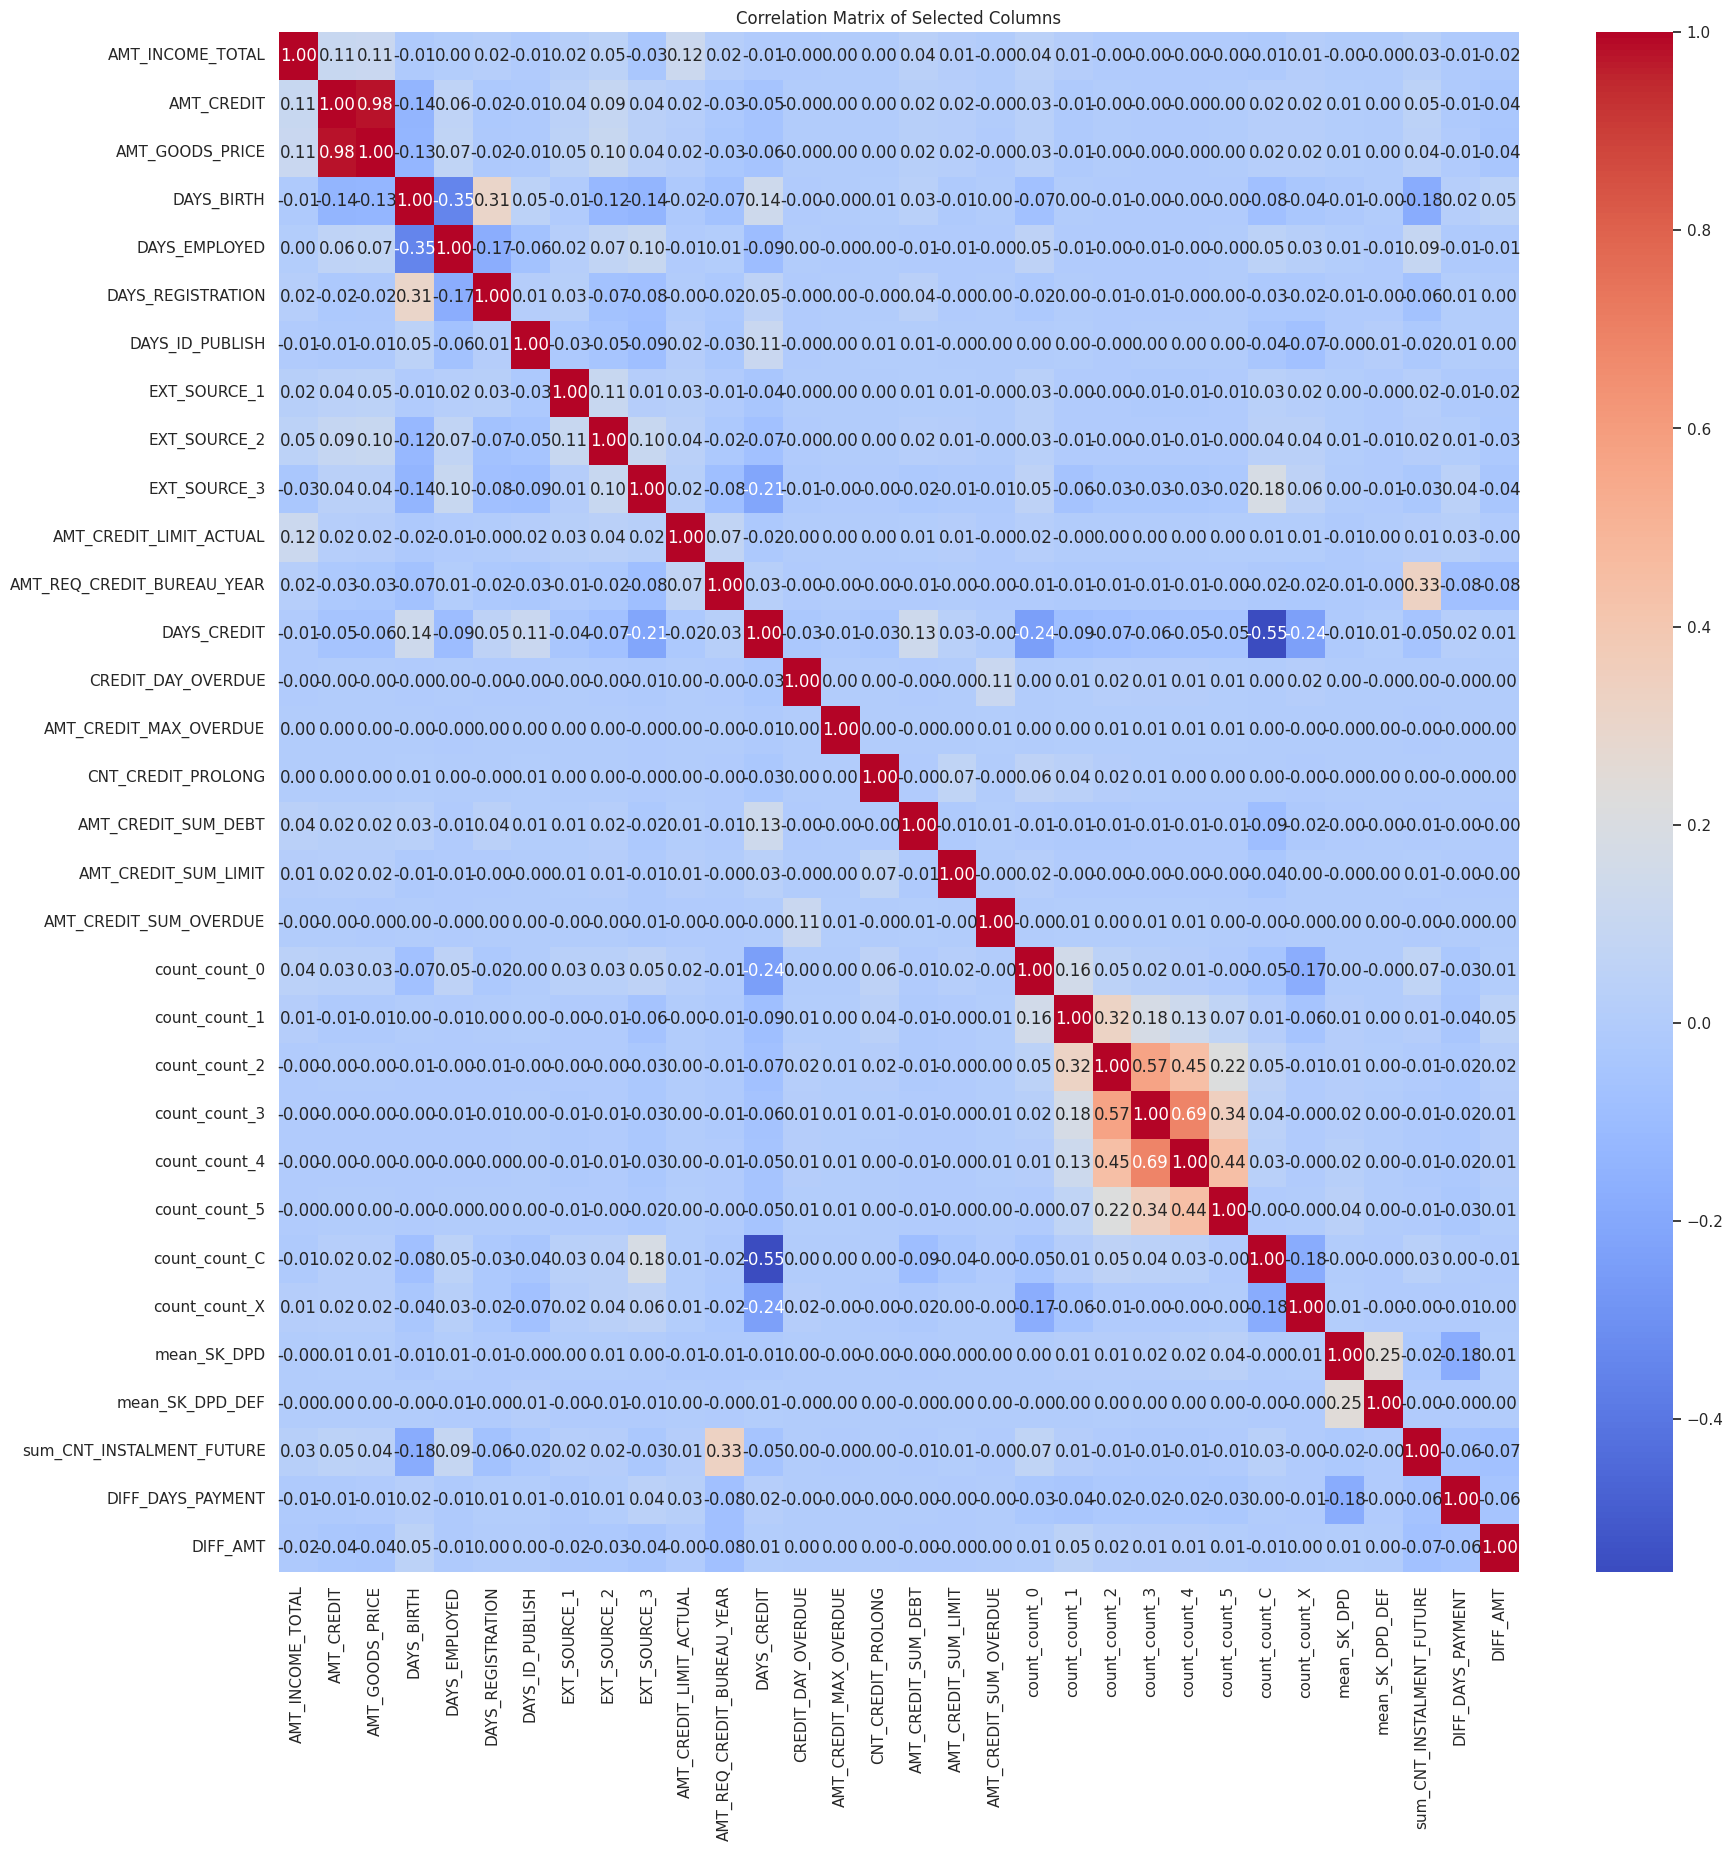

In [122]:
columns_to_select = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 
    'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 
    'count_count_0', 'count_count_1', 'count_count_2', 'count_count_3', 'count_count_4', 'count_count_5', 
    'count_count_C', 'count_count_X', 'mean_SK_DPD', 'mean_SK_DPD_DEF', 'sum_CNT_INSTALMENT_FUTURE', 
    'DIFF_DAYS_PAYMENT', 'DIFF_AMT'
]

selected_X_train = X_train[columns_to_select]

correlation_matrix = selected_X_train.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Selected Columns')
plt.show()

<div id="modeladodedatos" style="text-align: center;">
    <h2><u>Modelado</u></h2>
</div>

<div id="intromodelado" style="text-align: left;">
    <h3><u>Introducción</u></h3>
</div>

En este proyecto, se implementaron dos técnicas clave para mejorar el rendimiento del modelo: selección de features utilizand SelectFromModel, herramienta de scikit-learn y optimización de hiperparámetros mediante GridSearchCV. 

Para los distintos modelos ejecutados, se selecciono mediante SelectFromModel, las características más relevantes basadas en la importancia de las características evaluadas por los distintos modelos, tomando los distintos niveles de thresholds (0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean')

El parámetro threshold en SelectFromModel en Scikit-learn define el criterio para seleccionar las características más importantes. Este criterio puede basarse en la importancia de las características según un estimador entrenado. A continuación, se explica cada una de las opciones para threshold que mencionaste:

- 0.1, 0.2, 0.3: Estas son valores absolutos. Las características con una importancia mayor o igual al valor especificado serán seleccionadas. Por ejemplo, si threshold=0.1, solo las características cuya importancia sea igual o superior a 0.1 serán retenidas.

- 'median': Selecciona las características cuya importancia sea mayor o igual a la mediana de las importancias de todas las características. Esto significa que aproximadamente la mitad de las características serán seleccionadas, aquellas cuya importancia está por encima de la mediana.

- 'mean': Selecciona las características cuya importancia sea mayor o igual a la media (promedio) de las importancias de todas las características. Esto tiende a seleccionar características con una importancia superior al promedio.

- '1.25*mean': Selecciona las características cuya importancia sea mayor o igual a 1.25 veces la media de las importancias. Este es un umbral más estricto que solo seleccionará las características con una importancia significativamente mayor que el promedio.

- '2*mean': Selecciona las características cuya importancia sea mayor o igual a 2 veces la media de las importancias. Este es un umbral aún más estricto, reteniendo solo las características más importantes.

El resultado de SelectFromModel es un conjunto reducido de características que contribuyen significativamente al rendimiento del modelo. Esto ayuda a reducir la dimensionalidad y a eliminar características irrelevantes o redundantes.

Una vez seleccionadas las características, se define el modelo y el rango de hiperparámetros a evaluar. En este caso, se utilizo el modelo DecisionTreeClassifier, por su buenos resultados y su bajo tiempo de ejecución comparado con otros modelos.

Se emplea GridSearchCV para realizar una búsqueda exhaustiva de la mejor combinación de hiperparámetros. La búsqueda se realiza utilizando cross validation para asegurar la generalización del modelo.

In [109]:
X_train = X_train.select_dtypes(include=['float', 'int'])

In [110]:
contar_valores_nulos_con_porcentaje(X_train)

,Cantidad de Nulos,Porcentaje de Nulos (%)
SK_ID_CURR,0,0.000000
TARGET,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
...,...,...
DIFF_DAYS_PAYMENT,43909,3.833093
DIFF_AMT,43909,3.833093
AMT_BALANCE,777434,67.867107
AMT_CREDIT_LIMIT_ACTUAL,777434,67.867107


In [111]:
X_train.fillna(0, inplace=True)

In [112]:
X = X_train.drop(columns=['SK_ID_CURR', 'TARGET'])  # Features
y = X_train['TARGET']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<div id="selectfrommodel" style="text-align: left;">
    <h3><u>Select From Model</u></h3>
</div>

##### Regresión Logistica

In [213]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

thresholds = [0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean']

results = {
    'Threshold': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train Precision': [],
    'Test Precision': [],
    'Train Recall': [],
    'Test Recall': [],
    'Train F1': [],
    'Test F1': [],
    'Train ROC AUC': [],
    'Test ROC AUC': []
}

for threshold in thresholds:
    print("Threshold:", threshold)
    
    selector = SelectFromModel(estimator=LogisticRegression(class_weight='balanced', max_iter=10000), threshold=threshold)
    selector.fit(X_train_scaled, y_train)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    lr_model_selected = LogisticRegression(class_weight='balanced', max_iter=10000)
    lr_model_selected.fit(X_train_selected, y_train)

    lr_train_pred = lr_model_selected.predict(X_train_selected)
    lr_test_pred = lr_model_selected.predict(X_test_selected)
    
    results['Threshold'].append(str(threshold))
    results['Train Accuracy'].append(accuracy_score(y_train, lr_train_pred))
    results['Test Accuracy'].append(accuracy_score(y_test, lr_test_pred))
    results['Train Precision'].append(precision_score(y_train, lr_train_pred, average='weighted'))
    results['Test Precision'].append(precision_score(y_test, lr_test_pred, average='weighted'))
    results['Train Recall'].append(recall_score(y_train, lr_train_pred, average='weighted'))
    results['Test Recall'].append(recall_score(y_test, lr_test_pred, average='weighted'))
    results['Train F1'].append(f1_score(y_train, lr_train_pred, average='weighted'))
    results['Test F1'].append(f1_score(y_test, lr_test_pred, average='weighted'))
    results['Train ROC AUC'].append(roc_auc_score(y_train, lr_train_pred, average='weighted', multi_class='ovr'))
    results['Test ROC AUC'].append(roc_auc_score(y_test, lr_test_pred, average='weighted', multi_class='ovr'))

results_df = pd.DataFrame(results)

results_df

Threshold: 0.1
Threshold: 0.2
Threshold: 0.3
Threshold: median
Threshold: mean
Threshold: 1.25*mean
Threshold: 2*mean


,Threshold,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC AUC,Test ROC AUC
0,0.1,0.683894,0.683171,0.890895,0.890972,0.683894,0.683171,0.752949,0.752678,0.684843,0.682599
1,0.2,0.678121,0.677768,0.888370,0.888703,0.678121,0.677768,0.748516,0.748536,0.674608,0.673307
2,0.3,0.670759,0.670906,0.885558,0.886415,0.670759,0.670906,0.742868,0.743286,0.663099,0.663729
3,median,0.685930,0.685528,0.891461,0.891818,0.685930,0.685528,0.754499,0.754478,0.687282,0.686139
4,mean,0.684349,0.683508,0.890931,0.890967,0.684349,0.683508,0.753292,0.752930,0.685058,0.682643
5,1.25*mean,0.683951,0.683355,0.890784,0.890908,0.683951,0.683355,0.752988,0.752813,0.684449,0.682397
6,2*mean,0.678855,0.678785,0.888953,0.889281,0.678855,0.678785,0.749089,0.749321,0.676858,0.675604


##### Decision Tree

In [216]:
results = {
    'Threshold': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train Precision': [],
    'Test Precision': [],
    'Train Recall': [],
    'Test Recall': [],
    'Train F1': [],
    'Test F1': [],
    'Train ROC AUC': [],
    'Test ROC AUC': []
}

thresholds = [0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean']

for threshold in thresholds:
    print("Threshold:", threshold)

    selector = SelectFromModel(estimator=DecisionTreeClassifier(class_weight='balanced'), threshold=threshold)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    dt_model_selected = DecisionTreeClassifier(class_weight='balanced')
    dt_model_selected.fit(X_train_selected, y_train)
    dt_train_pred = dt_model_selected.predict(X_train_selected)
    dt_test_pred = dt_model_selected.predict(X_test_selected)

    results['Threshold'].append(threshold)
    results['Train Accuracy'].append(accuracy_score(y_train, dt_train_pred))
    results['Test Accuracy'].append(accuracy_score(y_test, dt_test_pred))
    results['Train Precision'].append(precision_score(y_train, dt_train_pred, average='weighted'))
    results['Test Precision'].append(precision_score(y_test, dt_test_pred, average='weighted'))
    results['Train Recall'].append(recall_score(y_train, dt_train_pred, average='weighted'))
    results['Test Recall'].append(recall_score(y_test, dt_test_pred, average='weighted'))
    results['Train F1'].append(f1_score(y_train, dt_train_pred, average='weighted'))
    results['Test F1'].append(f1_score(y_test, dt_test_pred, average='weighted'))
    results['Train ROC AUC'].append(roc_auc_score(y_train, dt_train_pred, average='weighted'))
    results['Test ROC AUC'].append(roc_auc_score(y_test, dt_test_pred, average='weighted'))

results_df = pd.DataFrame(results)

results_df

Threshold: 0.1
Threshold: 0.2
No features selected with threshold 0.2
Threshold: 0.3
No features selected with threshold 0.3
Threshold: median
Threshold: mean
Threshold: 1.25*mean
Threshold: 2*mean


,Threshold,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC AUC,Test ROC AUC
0,0.1,0.633241,0.631431,0.87996,0.880047,0.633241,0.631431,0.713861,0.712761,0.636641,0.634050
1,median,1.000000,0.987482,1.00000,0.987523,1.000000,0.987482,1.000000,0.987501,1.000000,0.961443
2,mean,1.000000,0.988569,1.00000,0.988576,1.000000,0.988569,1.000000,0.988572,1.000000,0.963685
3,1.25*mean,1.000000,0.988621,1.00000,0.988630,1.000000,0.988621,1.000000,0.988625,1.000000,0.963900
4,2*mean,1.000000,0.988224,1.00000,0.988247,1.000000,0.988224,1.000000,0.988235,1.000000,0.963218


##### Random Forest

In [217]:
results = {
    'Threshold': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train Precision': [],
    'Test Precision': [],
    'Train Recall': [],
    'Test Recall': [],
    'Train F1': [],
    'Test F1': [],
    'Train ROC AUC': [],
    'Test ROC AUC': []
}

thresholds = [0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean']

for threshold in thresholds:
    print("Threshold:", threshold)

    selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, class_weight='balanced'), threshold=threshold)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    rf_model_selected = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    rf_model_selected.fit(X_train_selected, y_train)
    rf_train_pred = rf_model_selected.predict(X_train_selected)
    rf_test_pred = rf_model_selected.predict(X_test_selected)

    results['Threshold'].append(threshold)
    results['Train Accuracy'].append(accuracy_score(y_train, rf_train_pred))
    results['Test Accuracy'].append(accuracy_score(y_test, rf_test_pred))
    results['Train Precision'].append(precision_score(y_train, rf_train_pred, average='weighted'))
    results['Test Precision'].append(precision_score(y_test, rf_test_pred, average='weighted'))
    results['Train Recall'].append(recall_score(y_train, rf_train_pred, average='weighted'))
    results['Test Recall'].append(recall_score(y_test, rf_test_pred, average='weighted'))
    results['Train F1'].append(f1_score(y_train, rf_train_pred, average='weighted'))
    results['Test F1'].append(f1_score(y_test, rf_test_pred, average='weighted'))
    results['Train ROC AUC'].append(roc_auc_score(y_train, rf_train_pred, average='weighted', multi_class='ovr'))
    results['Test ROC AUC'].append(roc_auc_score(y_test, rf_test_pred, average='weighted', multi_class='ovr'))

results_df = pd.DataFrame(results)

results_df

Threshold: 0.1
No features selected with threshold 0.1
Threshold: 0.2
No features selected with threshold 0.2
Threshold: 0.3
No features selected with threshold 0.3
Threshold: median
Threshold: mean
Threshold: 1.25*mean
Threshold: 2*mean


,Threshold,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC AUC,Test ROC AUC
0,median,0.999996,0.991035,0.999996,0.991120,0.999996,0.991035,0.999996,0.990808,0.999975,0.947458
1,mean,0.999996,0.991484,0.999996,0.991557,0.999996,0.991484,0.999996,0.991282,0.999975,0.950258
2,1.25*mean,0.999997,0.991794,0.999997,0.991864,0.999997,0.991794,0.999997,0.991606,0.999981,0.952006
3,2*mean,0.999998,0.993331,0.999998,0.993375,0.999998,0.993331,0.999998,0.993208,0.999987,0.961088


##### XGBoost

In [215]:
results = {
    'Threshold': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train Precision': [],
    'Test Precision': [],
    'Train Recall': [],
    'Test Recall': [],
    'Train F1': [],
    'Test F1': [],
    'Train ROC AUC': [],
    'Test ROC AUC': [],
    'Train Confusion Matrix': [],
    'Test Confusion Matrix': []
}

thresholds = [0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean']

for threshold in thresholds:
    print("Threshold:", threshold)

    xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
    selector = SelectFromModel(estimator=xgb_model, threshold=threshold)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    xgb_model_selected = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    xgb_model_selected.fit(X_train_selected, y_train)
    xgb_train_pred = xgb_model_selected.predict(X_train_selected)
    xgb_test_pred = xgb_model_selected.predict(X_test_selected)

    results['Threshold'].append(threshold)
    results['Train Accuracy'].append(accuracy_score(y_train, xgb_train_pred))
    results['Test Accuracy'].append(accuracy_score(y_test, xgb_test_pred))
    results['Train Precision'].append(precision_score(y_train, xgb_train_pred, average='weighted'))
    results['Test Precision'].append(precision_score(y_test, xgb_test_pred, average='weighted'))
    results['Train Recall'].append(recall_score(y_train, xgb_train_pred, average='weighted'))
    results['Test Recall'].append(recall_score(y_test, xgb_test_pred, average='weighted'))
    results['Train F1'].append(f1_score(y_train, xgb_train_pred, average='weighted'))
    results['Test F1'].append(f1_score(y_test, xgb_test_pred, average='weighted'))
    results['Train ROC AUC'].append(roc_auc_score(y_train, xgb_train_pred, average='weighted', multi_class='ovr'))
    results['Test ROC AUC'].append(roc_auc_score(y_test, xgb_test_pred, average='weighted', multi_class='ovr'))
    results['Train Confusion Matrix'].append(confusion_matrix(y_train, xgb_train_pred))
    results['Test Confusion Matrix'].append(confusion_matrix(y_test, xgb_test_pred))

results_df = pd.DataFrame(results)

results_df

Threshold: 0.1
No features selected with threshold 0.1
Threshold: 0.2
No features selected with threshold 0.2
Threshold: 0.3
No features selected with threshold 0.3
Threshold: median
Threshold: mean
Threshold: 1.25*mean
Threshold: 2*mean


,Threshold,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC AUC,Test ROC AUC,Train Confusion Matrix,Test Confusion Matrix
0,median,0.928379,0.926680,0.927018,0.922776,0.928379,0.926680,0.905922,0.902979,0.591156,0.580927,"[[836307, 1452], [64183, 14477]]","[[209102, 474], [16324, 3205]]"
1,mean,0.928297,0.926850,0.926595,0.923370,0.928297,0.926850,0.905878,0.903181,0.591198,0.581368,"[[836217, 1542], [64168, 14492]]","[[209126, 450], [16309, 3220]]"
2,1.25*mean,0.925642,0.924607,0.923785,0.920805,0.925642,0.924607,0.900509,0.898458,0.574419,0.566722,"[[836445, 1314], [66829, 11831]]","[[209190, 386], [16887, 2642]]"
3,2*mean,0.918537,0.918369,0.913276,0.909692,0.918537,0.918369,0.884989,0.884475,0.530273,0.527071,"[[836924, 835], [73819, 4841]]","[[209322, 254], [18448, 1081]]"


##### LightGBM

In [212]:
results = {
    'Threshold': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train Precision': [],
    'Test Precision': [],
    'Train Recall': [],
    'Test Recall': [],
    'Train F1': [],
    'Test F1': [],
    'Train ROC AUC': [],
    'Test ROC AUC': []
}

for threshold in thresholds:
    print("Threshold:", threshold)
    selector = SelectFromModel(estimator=lgb.LGBMClassifier(objective='binary', class_weight='balanced'), threshold=threshold)
    selector.fit(X_train_scaled, y_train)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    lgbm_model = lgb.LGBMClassifier(objective='binary', class_weight='balanced')
    lgbm_model.fit(X_train_selected, y_train)
    lgbm_train_pred = lgbm_model.predict(X_train_selected)
    lgbm_test_pred = lgbm_model.predict(X_test_selected)

    results['Threshold'].append(str(threshold))
    results['Train Accuracy'].append(accuracy_score(y_train, lgbm_train_pred))
    results['Test Accuracy'].append(accuracy_score(y_test, lgbm_test_pred))
    results['Train Precision'].append(precision_score(y_train, lgbm_train_pred, average='weighted'))
    results['Test Precision'].append(precision_score(y_test, lgbm_test_pred, average='weighted'))
    results['Train Recall'].append(recall_score(y_train, lgbm_train_pred, average='weighted'))
    results['Test Recall'].append(recall_score(y_test, lgbm_test_pred, average='weighted'))
    results['Train F1'].append(f1_score(y_train, lgbm_train_pred, average='weighted'))
    results['Test F1'].append(f1_score(y_test, lgbm_test_pred, average='weighted'))
    results['Train ROC AUC'].append(roc_auc_score(y_train, lgbm_train_pred, average='weighted', multi_class='ovr'))
    results['Test ROC AUC'].append(roc_auc_score(y_test, lgbm_test_pred, average='weighted', multi_class='ovr'))

results_df = pd.DataFrame(results)

results_df

Threshold: 0.1
[LightGBM] [Info] Number of positive: 78660, number of negative: 837759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15526
[LightGBM] [Info] Number of data points in the train set: 916419, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 78660, number of negative: 837759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14829
[LightGBM] [Info] Number of data points in the train set: 916419, number of used features:

,Threshold,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC AUC,Test ROC AUC
0,0.1,0.731202,0.728662,0.904628,0.903550,0.731202,0.728662,0.788707,0.786998,0.744349,0.737762
1,0.2,0.731202,0.728662,0.904628,0.903550,0.731202,0.728662,0.788707,0.786998,0.744349,0.737762
2,0.3,0.731202,0.728662,0.904628,0.903550,0.731202,0.728662,0.788707,0.786998,0.744349,0.737762
3,median,0.730593,0.727937,0.904938,0.903800,0.730593,0.727937,0.788283,0.786486,0.745393,0.738573
4,mean,0.726927,0.724633,0.903270,0.902599,0.726927,0.724633,0.785489,0.783990,0.738486,0.733447
5,1.25*mean,0.726601,0.724502,0.903294,0.902759,0.726601,0.724502,0.785252,0.783904,0.738515,0.734026
6,2*mean,0.727434,0.724598,0.903108,0.902614,0.727434,0.724598,0.785849,0.783965,0.737974,0.733498


<div id="gridsearch" style="text-align: left;">
    <h4><u>GridSearch</u></h4>
</div>

In [113]:
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=DecisionTreeClassifier(), threshold='1.25*mean')),
    ('classifier', DecisionTreeClassifier(class_weight='balanced'))
])

param_grid = {
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

train_precision = precision_score(y_train, train_preds, average='weighted')
test_precision = precision_score(y_test, test_preds, average='weighted')

train_recall = recall_score(y_train, train_preds, average='weighted')
test_recall = recall_score(y_test, test_preds, average='weighted')

train_f1 = f1_score(y_train, train_preds, average='weighted')
test_f1 = f1_score(y_test, test_preds, average='weighted')

train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr') if len(np.unique(y_train)) > 2 else roc_auc_score(y_train, train_preds)
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr') if len(np.unique(y_test)) > 2 else roc_auc_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Test Precision: {test_precision}")
print(f"Training Recall: {train_recall}")
print(f"Test Recall: {test_recall}")
print(f"Training F1-Score: {train_f1}")
print(f"Test F1-Score: {test_f1}")
print(f"Training AUC-ROC: {train_auc}")
print(f"Test AUC-ROC: {test_auc}")

print("Training Confusion Matrix:\n", confusion_matrix(y_train, train_preds))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
print("Training Classification Report:\n", classification_report(y_train, train_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Training Accuracy: 0.9850745128592925
Test Accuracy: 0.9711573296086947
Training Precision: 0.9872854207532321
Test Precision: 0.9754416311099179
Training Recall: 0.9850745128592925
Test Recall: 0.9711573296086947
Training F1-Score: 0.985610028917811
Test F1-Score: 0.9724581382421984
Training AUC-ROC: 0.9918365544267503
Test AUC-ROC: 0.9583244630618185
Training Confusion Matrix:
 [[824081  13678]
 [     0  78660]]
Test Confusion Matrix:
 [[204084   5492]
 [  1116  18413]]
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    837759
           1       0.85      1.00      0.92     78660

    accuracy                           0.99    916419
   macro avg       0.93      0.99      0.96    916419
weighted avg       0.99      0.99  

In [115]:
final_estimator = best_model.named_steps['classifier']

importancias = final_estimator.feature_importances_

feature_selector = best_model.named_steps['feature_selection']
selected_features = feature_selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]

importancias_df = pd.DataFrame({'caracteristica': selected_feature_names, 'importancia': importancias})

importancias_df = importancias_df.sort_values(by='importancia', ascending=False)
print(importancias_df)

                caracteristica  importancia
12                EXT_SOURCE_3     0.136064
11                EXT_SOURCE_2     0.104115
6                DAYS_EMPLOYED     0.058801
8              DAYS_ID_PUBLISH     0.052201
5                   DAYS_BIRTH     0.051984
2                  AMT_ANNUITY     0.051361
15                SK_ID_BUREAU     0.051148
7            DAYS_REGISTRATION     0.050321
10                EXT_SOURCE_1     0.047652
19           DIFF_DAYS_PAYMENT     0.045982
13      DAYS_LAST_PHONE_CHANGE     0.043986
18   sum_CNT_INSTALMENT_FUTURE     0.043208
4   REGION_POPULATION_RELATIVE     0.039342
0             AMT_INCOME_TOTAL     0.033051
20                    DIFF_AMT     0.032997
1                   AMT_CREDIT     0.032115
9      HOUR_APPR_PROCESS_START     0.026459
3              AMT_GOODS_PRICE     0.025550
14  AMT_REQ_CREDIT_BUREAU_YEAR     0.015720
21                 AMT_BALANCE     0.015685
22     AMT_CREDIT_LIMIT_ACTUAL     0.014730
16                 mean_SK_DPD  

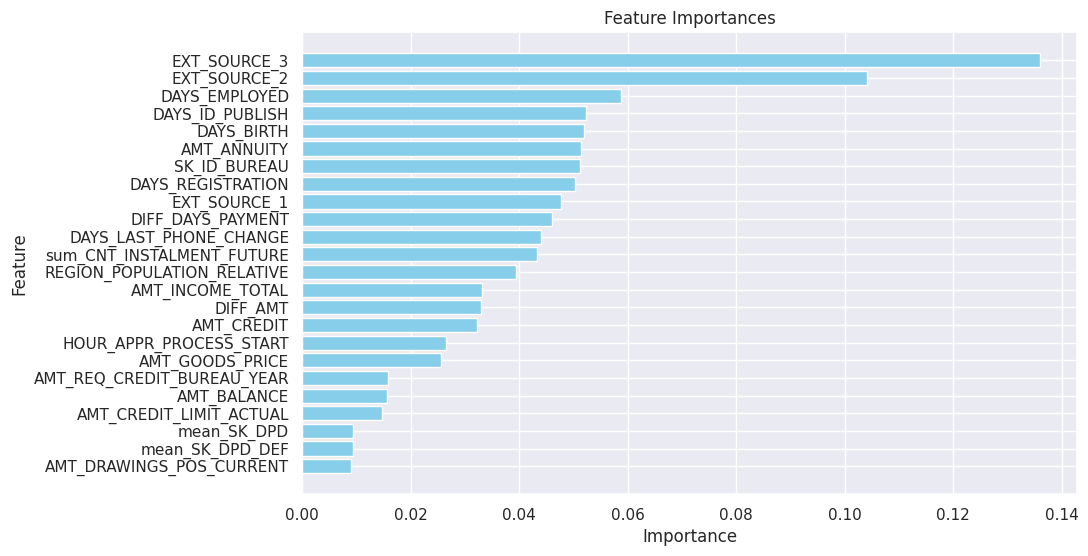

In [ ]:
importancias_df = importancias_df.sort_values(by='importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importancias_df['caracteristica'], importancias_df['importancia'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


<div id="conclusion" style="text-align: left;">
    <h4><u>Conclusión</u></h4>
</div>

Mediante la aplicación de SelectFromModel y GridSearchCV, se logró mejorar significativamente el rendimiento del modelo. La selección de características permitió enfocarse en las variables más importantes, mientras que la optimización de hiperparámetros afinó el modelo para maximizar su precisión. Estos pasos son fundamentales para construir modelos de machine learning más eficientes y precisos.

El modelo desarrollado mostró un desempeño robusto en la predicción del modelo. 

Para optimizar el rendimiento del modelo, se empleó una búsqueda exhaustiva de hiperparámetros mediante Grid Search. Esta técnica permitió identificar la combinación óptima de hiperparámetros que maximiza la precisión del modelo. Utilizando cross validation con cv = 5, se evaluaron diversas configuraciones de parámetros.

El modelo muestra una alta precisión y recall en ambos conjuntos de datos, lo que indica que es capaz de identificar correctamente tanto a los clientes elegibles como a los no elegibles para los préstamos con un alto grado de exactitud.

Por otra parte, el balance entre precisión y recall sugiere que el modelo es robusto y no está sesgado hacia falsos positivos o falsos negativos. Esto es crucial en la evaluación del riesgo crediticio para minimizar las decisiones erróneas.

Un AUC-ROC de 0.9583 en el conjunto de prueba indica que el modelo tiene una excelente capacidad de discriminación entre las clases (elegible y no elegible).

Por último, importante aclarar que la presencia de clases desbalanceadas en el conjunto de datos pudo afectar la precisión del modelo con respecto a la clase minoritaria. En este proyecto se tomaron medidas ajustando los hiperparámetros en cada uno de los modelos.

La cantidad de los datos complejizo al momento de utilizar SelectFromModel y luego al implementar GridSearchCV.

<div id="interpretacionresultados" style="text-align: left;">
    <h3><u>Interpretación de Resultados</u></h3>
</div>

Para interpretar los resultados del análisis de importancia de las características, es esencial entender el papel de cada variable. A continuación, se presenta una interpretación detallada organizada por categoría:

**Características Externas**

- EXT_SOURCE_3 (0.136064) y EXT_SOURCE_2 (0.104115):

Importancia: Son las más influyentes en el modelo, indicando que estas evaluaciones externas son cruciales para determinar la elegibilidad del cliente para un préstamo.

- EXT_SOURCE_1 (0.047652):

Importancia: Aunque ligeramente menos importante que las dos primeras, sigue siendo vital para evaluar el riesgo del cliente.

**Empleo y Estabilidad**

- DAYS_EMPLOYED (0.058801):

Importancia: Un empleo estable y prolongado es un buen indicador de solvencia y capacidad de pago.

- DAYS_ID_PUBLISH (0.052201):

Importancia: Indica la estabilidad del cliente en términos de su identidad.

- DAYS_LAST_PHONE_CHANGE (0.043986):

Importancia: Puede ser un indicador indirecto de estabilidad personal y financiera.

- DAYS_REGISTRATION (0.050321):

Importancia: Refleja la antigüedad y la lealtad del cliente con la institución.

**Datos Financieros**

- AMT_ANNUITY (0.051361):

Importancia: Refleja la carga financiera recurrente del cliente, crucial para evaluar su capacidad de pago.

- AMT_CREDIT (0.032115):

Importancia: Ayuda a evaluar la relación deuda-ingreso del cliente.

AMT_INCOME_TOTAL (0.033051):

Importancia: Fundamental para determinar la capacidad de pago del cliente.

- AMT_GOODS_PRICE (0.025550):

Importancia: Refleja la naturaleza y el tamaño de la compra, lo que puede influir en la evaluación del préstamo.

**Comportamiento y Historial**

- DIFF_DAYS_PAYMENT (0.045982):

Importancia: Esencial para evaluar la puntualidad y confiabilidad del cliente en sus pagos.

- sum_CNT_INSTALMENT_FUTURE (0.043208):

Importancia: Indica la carga financiera futura del cliente y su capacidad para manejar nuevas deudas.

**Otras Características**

- DAYS_BIRTH (0.051984):

Importancia: La edad puede correlacionarse con la estabilidad financiera y la responsabilidad crediticia. También puede correlacionarse con la escaso historial del cliente debido a la edad.
